#1.Create only image CSV

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

### mp3ToWav

In [ ]:
import os
import subprocess

# Set the path to the input MP3 folder
input_folder = '/content/gdrive/MyDrive/prj_data/new_data/'   #/content/gdrive/MyDrive/prj_data/new data/

# Set the path to the output WAV folder
output_folder = '/content/gdrive/MyDrive/wav_files/new_data/'

In [ ]:
# # **************** run just one time for make wave files ***************

# Get a list of all the MP3 files in the input folder
mp3_files = [f for f in os.listdir(input_folder) if f.endswith('.mp3')]

# Loop over each MP3 file and convert it to WAV
for mp3_file in mp3_files:
    mp3_path = os.path.join(input_folder, mp3_file)
    wav_path = os.path.join(output_folder, os.path.splitext(mp3_file)[0] + '.wav')
    subprocess.run(['ffmpeg', '-i', mp3_path, wav_path])

## speech to text

In [ ]:
!apt-get update
!apt-get install g++ git make zlib1g-dev

In [ ]:
!git clone https://github.com/kaldi-asr/kaldi.git

In [ ]:
%cd kaldi

In [ ]:
!cd tools && make && cd ..
!./configure --shared --mathlib=ATLAS --use-cuda=no
!make depend -j $(nproc)
!make -j $(nproc)

In [ ]:
# !wget 'https://github.com/rhasspy/fa_kaldi-rhasspy/releases/download/v1.0/vosk-model-small-fa-rhasspy-0.15.zip'
# !unzip vosk-model-small-fa-rhasspy-0.15.zip

In [ ]:
!pip install kaldi_io

In [ ]:
!pip install vosk

In [ ]:
!export KALDI_ROOT=/content/kaldi

In [ ]:
!source ~/.bashrc

In [ ]:
!wget 'https://github.com/rhasspy/fa_kaldi-rhasspy/releases/download/v1.0/vosk-model-small-fa-rhasspy-0.15.zip'
!unzip vosk-model-small-fa-rhasspy-0.15.zip


In [ ]:
import wave
import os
import wave
import json
import kaldi_io
import numpy as np
import pandas as pd
from vosk import Model, KaldiRecognizer

# Set the paths to the acoustic and language models
acoustic_model_path = "/content/gdrive/MyDrive/prj_data/kaldi/vosk-model-small-fa-rhasspy-0.15"
lang_model_path = "/content/gdrive/MyDrive/prj_data/kaldi/vosk-model-small-fa-rhasspy-0.15/graph/Gr.fst"

# Create an empty DataFrame to store the recognition results
results_df = pd.DataFrame(columns=['file_name', 'transcript'])


# Loop through each WAV file in the directory
wav_dir = "/content/gdrive/MyDrive/wav_files/new_data/"
for file_name in os.listdir(wav_dir):
    if file_name.endswith(".wav"):
        # Load the WAV file for recognition
        audio_file_path = os.path.join(wav_dir, file_name)
        audio_file = wave.open(audio_file_path, 'rb')

        # Get the sample rate (framerate)
        sample_rate = audio_file.getframerate()

        # Load the acoustic and language models
        acoustic_model = Model(acoustic_model_path)
        lang_model = KaldiRecognizer(acoustic_model, sample_rate)

        # Perform speech recognition on the audio file
        while True:
            # Read a chunk of audio data from the file
            audio_data = audio_file.readframes(4000)

            # Break out of the loop when there's no more audio data
            if len(audio_data) == 0:
                break

            # Convert the audio data to a numpy array
            audio_numpy = np.frombuffer(audio_data, dtype=np.int16)

            # Feed the audio data to the recognizer
            lang_model.AcceptWaveform(audio_numpy.tobytes())

        # Get the final recognition results
        result = lang_model.FinalResult()

        # Append the recognition result to the DataFrame
        results_df = results_df.append({'file_name': file_name, 'transcript': result}, ignore_index=True)

# Print the recognition results
print(results_df)


In [ ]:
results_df.sort_values("file_name", axis=0, ascending=True,inplace=True, na_position='first')
results_df

In [ ]:
df=results_df
df['transcript'] = df['transcript'].str.replace('{\n  "text" : ', '')
df['transcript'] = df['transcript'].str.replace('}', '')
df['file_name'] = df['file_name'].str.replace('_story1_study1.wav', '')
df

In [ ]:
df.to_csv("/content/gdrive/MyDrive/out.csv")

In [ ]:
# #concat first data and new data
# import pandas as pd
# df = pd.read_csv("/content/gdrive/MyDrive/out.csv", index_col=[0])
# df2=pd.read_csv("/content/gdrive/MyDrive/first_out.csv", index_col=[0])

# frames = [df, df2]
# dataset =  pd.concat(frames,ignore_index=True)
# dataset.to_csv("/content/gdrive/MyDrive/project_dataset.csv")
# dataset.to_excel("/content/gdrive/MyDrive/project_dataset.xlsx")
# dataset

split id and timeStamp from file name

In [ ]:
df2 = pd.DataFrame(df['file_name'])
df3 = df2['file_name'].str.split("_", expand = True)
df3.columns = ['STATUS_ID{}'.format(x+1) for x in df3.columns]
# print (df3)
#   STATUS_ID1 STATUS_ID2
# 0  48xdti2f  1681027836
# 1  48xdti2f  1681028046
df[['id', 'TimeStamp']] = df3[['STATUS_ID1', 'STATUS_ID2']]
df.to_csv("/content/gdrive/MyDrive/project_dataset_split.csv")
df.to_excel("/content/gdrive/MyDrive/project_dataset_split.xlsx")
df

## preproccess

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import pandas as pd
df = pd.read_excel("/content/gdrive/MyDrive/project_dataset_split_clean.xlsx", index_col=[0])
df

### find count of audios for delete incomplete data( handy)
and then must get just audios of pictures


In [ ]:
# groupby by id
# df.groupby("id", group_keys=True).apply(lambda x: x)

In [ ]:
# # groupby by id
# gk = df.groupby("id")
# # show first row of each subject
# gk.first()

In [ ]:
# #get one specific id
# gk.get_group('00i15xzd')

In [ ]:
# only run this cell
# compute count of audio of every subject
counter = df.groupby("id")["TimeStamp"].count()
temp= pd.DataFrame(counter).reset_index()
temp.rename(columns={"TimeStamp": "count_of_audios"}, inplace=True)
print(temp)

df = df.join(temp.set_index('id'), on='id')

In [ ]:
#  process uncomplete data
counter = df.groupby("count_of_audios")["id"]
counter.first()

In [ ]:
# counter = df.groupby("count_of_audios")["id"].count()
# temp= pd.DataFrame(counter).reset_index()
# temp['id']=temp['id']/temp['count_of_audios']
# temp.rename(columns={"id": "count_of_subject"}, inplace=True)
# temp
# #(there is 106 person that they have 11 audio )
# count_of_audios	count_of_subject
# 0	            3	3.0
# 1	            4	1.0
# 2	            5	1.0
# 3	            7	2.0
# 4	            8	2.0
# 5	            9	2.0
# 6	            10	10.0
# 7	            11	106.0
# 8	            13	1.0
# 9	            14	1.0
# 10	          22	3.0

In [ ]:
# # delete uncomplete data one by one
# # groupby by count_of_audios
# group_count = df.groupby("count_of_audios")
# # get one specific id
# group_count.get_group(3) #2gwcrwvh ,33gukzxe,p8pzxt7r
# group_count.get_group(4) #3bjlx7hv
# group_count.get_group(5)  #iw7hcndg
# group_count.get_group(7) #nng00uab ,ntmp3ned
# group_count.get_group(8) #vqelw7vi , (no64afbg ok)
# group_count.get_group(9) #r6gltob9 , (v4vf1g92 ok)
# group_count.get_group(10) #ua32y4cb ,['08oi5ot0' '4gqdsfum' 'fb1t8fvc' 'g7gmcvts' 'it0clbqf' 'kzlrvd2x'  'qdolnbxs' 'suia995m' 'syy20boc' ] ok
# group_count.get_group(22)

# # How to list unique id in pd.unique(group_count.get_group(10)
# len(pd.unique(group_count.get_group(8)['id']))

In [ ]:
#delete 3first rows about past,naw,future and just keep 8 audios about pictures
gb11 = df.groupby("count_of_audios").get_group(11)
only_images = gb11.drop(gb11.groupby("id").head(3).index, axis=0)

#add data with 8 audios
gb8 = df.groupby("count_of_audios").get_group(8)
result = pd.concat([only_images, gb8])
result.to_csv("/content/gdrive/MyDrive/project_dataset_split_clean_OnlyImages.csv")
result

### read only images csv

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import pandas as pd
df=pd.read_excel("/content/gdrive/MyDrive/project_dataset_split_clean_OnlyImages1.xlsx")
df

# 2.compute BDI

if you want to do it multi times, you must run first block and then next block, but if you want to run it just one times justrun first block
## first block: read images csv and first BDI

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import pandas as pd
df=pd.read_excel("/content/gdrive/MyDrive/project_dataset_split_clean_OnlyImages1.xlsx")
df

### read and clean BDI

In [ ]:
BDI1 =pd.read_csv("/content/BDI_story1.csv",header=None)
BDI1.head(2)

In [ ]:
#get first character
for i in range(2,23):
  BDI1[i] = BDI1[i].str[0]

# Converting Multiple columns to int
for i in range (2,23):
  BDI1 = BDI1.astype({i:"int"})

#compute scores
sum=0
BDI1["BDI_score"] = pd.Series(dtype='int')

for j in range(1,BDI1.shape[0]-1):
  for i in range(2,BDI1.shape[1]-1):
    sum = sum + BDI1[i][j]
  BDI1["BDI_score"][j] = sum
  sum=0

#drop useless columns
for i in range(2,23):
  BDI1.drop([i], axis=1, inplace=True)
BDI1 = BDI1.drop([0])
BDI1.rename(columns = {0:'BDI_timestamp',1:'id' }, inplace = True)
BDI1

In [ ]:
#delete duplicated rows and null values raws
temp = BDI1.sort_values('id', ascending=False)
BDI1 = temp.drop_duplicates(subset='id', keep='first').dropna(axis=0)
BDI1

In [ ]:
#fix changed id Handy
BDI1 = BDI1.replace('اذر', 'lsyku5px')
BDI1 = BDI1.replace('مینا', '8kfkpopv')

In [ ]:
# #see row from a specific id
# BDI1.loc[BDI1['id']=='10xj3h72']

### merge df and BDI

In [ ]:
print(df.shape , BDI1.shape)

In [ ]:
left_merged1 = pd.merge(df, BDI1, how="left", on=["id"])
left_merged1.shape

##second block:read only second BDI csv

In [ ]:
BDI =pd.read_csv("/content/BDI_bonyad01.csv",header=None)
BDI.head(2)

In [ ]:
for i in range(2,23):
  BDI[i] = BDI[i].str[0]

# Converting Multiple columns to int
for i in range (2,23):
  BDI = BDI.astype({i:"int"})

#compute BDI score
sum=0
BDI["BDI_score"] = pd.Series(dtype='int')

for j in range(1,BDI.shape[0]-1):
  for i in range(2,BDI.shape[1]-1):
    sum = sum + BDI[i][j]
  BDI["BDI_score"][j] = sum
  sum=0

#delete extra columns
for i in range(2,23):
  BDI.drop([i], axis=1, inplace=True)
BDI = BDI.drop([0])
BDI.rename(columns = {0:'BDI_timestamp',1:'id' }, inplace = True)
BDI.shape

In [ ]:
temp = BDI.sort_values('id', ascending=False)
BDI = temp.drop_duplicates(subset='id', keep='first')

In [ ]:
print(df.shape , BDI.shape)

In [ ]:
left_merged = pd.merge(df, BDI, how="left", on=["id"])
left_merged.shape

In [ ]:
# with pd.option_context('display.max_colwidth', None):
#   display(gk.get_group('zatfknoo'))

### merge first subjects and second subjects and delete Nan from final df

In [ ]:
print(left_merged1.shape , left_merged.shape) #(992, 7) (984, 7)
finaldf = pd.concat([left_merged1, left_merged]).dropna(axis=0)
finaldf

In [ ]:
#IDs that is in df but is not in final df
#they are not completed BDI -text them!
df['id'][~df['id'].isin(finaldf['id'])].unique()

# array(['10xj3h72', '2iaym4x3', '48xdti2f', '58ysvi8n', '8kfkpopv',
#        '913dtzkj', 'c5l9xs7r', 'de2k1rwl', 'dvw4pmpg', 'evgj8hnz',
#        'ff7sbzen', 'gssd0zh7', 'it0clbqf', 'kal5st0v', 'kegh0d5c',
#        'lr4xk13r', 'lsyku5px', 'n2geu19i', 'qmodslv6', 'szngczd2',
#        'v0vg2kj7', 'wijj2zsc', 'yq9g7cr4'], dtype=object)

#null :913dtzkjوkal5st0vوkegh0d5cوlr4xk13r

In [ ]:
# # see row from a specific id
# with pd.option_context('display.max_colwidth', None):
#   display(df.loc[df['id']=='qmodslv6'])

###check count of audios
check doubles row in BDI

In [ ]:
# # only run this cell
# # compute count of audio of every subject
# counter = finaldf.groupby("id")["TimeStamp"].count()
# temp= pd.DataFrame(counter).reset_index()
# temp.rename(columns={"TimeStamp": "count_of_audios"}, inplace=True)
# print(temp)
# finaldf = finaldf.join(temp.set_index('id'), on='id')

# #check if have duplicate id
# counter = finaldf.groupby("count_of_audios")["id"]
# counter.first()

In [ ]:
finaldf.to_excel("/content/gdrive/MyDrive/project_dataset_with_BDIscores.xlsx")
finaldf.to_csv("/content/gdrive/MyDrive/project_dataset_with_BDIscores.csv")

#3. categorization

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

##categories labels

Total Score ...................... Levels of Depression

1-10____________________These ups and downs are considered normal


11-16___________________ Mild mood disturbance


17-20___________________Borderline clinical depression


21-30___________________Moderate depression


31-40___________________Severe depression


over 40__________________Extreme depression

In [ ]:
import pandas as pd
# Read the CSV file into a pandas DataFrame
data = pd.read_csv('/content/gdrive/MyDrive/project_dataset_with_BDIscores.csv')
data

In [ ]:
# Define the bins and labels for categorization
bins = [0, 10, 16, 20, 30, 40,63]  ###################check this later
labels = ['normal', 'mild_dep', 'borderline_dep', 'moderate_dep', 'severe_dep','extreme_dep']

# Use pd.cut() to categorize the continuous labels into the specified categories
data['category'] = pd.cut(data['BDI_score'], bins=bins, labels=labels)

# Print the resulting DataFrame
data

In [ ]:
data['category_numeric'] = pd.factorize(data['category'])[0]
data.to_csv('/content/gdrive/MyDrive/project_dataset_with_BDIscores_categoriesd.csv', index=False)
# df=data

## groupby id

In [ ]:
import pandas as pd
df=pd.read_csv("/content/gdrive/MyDrive/project_dataset_with_BDIscores_categoriesd.csv").drop(['Unnamed: 0','count_of_audios'], axis=1)
df

In [ ]:
# Group by the 'id' column and compute the length of each group
grouped_df = df.groupby('id').apply(lambda x: len(x)).reset_index()

# Format the length column as xx.xx.xx
# Group by the 'id' column and compute the sum of the 'length' column for each group
grouped_df = df.groupby('id')['length'].apply(lambda x: x.astype(str).str.replace('.', '').astype(int).sum()).reset_index()
grouped_df

In [ ]:
# # Merge the grouped DataFrame with the original DataFrame

result_df = pd.merge(df, grouped_df, on='id')
result_df

In [ ]:
#convert second to minute
def converted(i):
  print(i)
  # Define the number of seconds
  seconds = i
  # Convert the seconds to hours, minutes, and seconds
  hours, seconds = divmod(seconds, 60 ** 2)
  minutes, seconds = divmod(seconds, 60)
  # Format the resulting hours, minutes, and seconds as xx.xx.xx
  formatted_time = '{:02d}.{:02d}.{:02d}'.format(hours, minutes, seconds)
  return(formatted_time)

In [ ]:
for j in range(grouped_df.shape[0]):
  grouped_df.loc[j, 'total_length'] = converted(grouped_df.loc[j, 'length'])

In [ ]:
grouped_df

In [ ]:
result_df = pd.merge(df, grouped_df, on='id')
result_df.to_csv('/content/gdrive/MyDrive/project_dataset_with_BDIscores_categoriesd_ComputedLength_MergedTranscripted_all.csv', index=False)
result_df

In [ ]:
# merge transcripts together with "|"
gk = result_df.groupby('id')['transcript'].apply(lambda x: '|'.join(x)).reset_index()
temp = pd.merge(result_df, gk, on='id')
categorized = temp.groupby(['id','total_length','category_numeric']).first().drop(columns=['file_name',
                                                                             'length_x',
                                                                             'BDI_timestamp',
                                                                             'BDI_score',
                                                                             'length_y',
                                                                             'transcript_x'])
categorized

In [ ]:
categorized.to_csv('/content/gdrive/MyDrive/project_dataset_with_BDIscores_categoriesd_ComputedLength_MergedTranscripted.csv', index=False)

 result_df #is all


 categorized #is grouped_by

###vectorised groupbied data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
# result_df =pd.read_csv('/content/gdrive/MyDrive/project_dataset_with_BDIscores_categoriesd_ComputedLength_MergedTranscripted_all.csv')
categorized =pd.read_csv('/content/gdrive/MyDrive/project_dataset_with_BDIscores_categoriesd_ComputedLength_MergedTranscripted.csv')

In [ ]:
!pip install transformers

In [ ]:
!sudo apt install python-pip
!pip install hazm

In [ ]:
from __future__ import unicode_literals
from hazm import *

In [ ]:
import nltk
nltk.download('punkt')

In [ ]:
categorized

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModel

# Load the ParsBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
model = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

# Define a function to vectorize the text
def vectorize_text(text):
    # Tokenize the text
    encoded_input = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors='pt')
    # Pass the tokenized input through the model
    with torch.no_grad():
        model_output = model(**encoded_input)
    # Extract the last hidden state of the model as the vector representation of the text
    vector = model_output.last_hidden_state[:, 0, :].squeeze().tolist()
    return vector


In [ ]:
dataset = categorized

# Vectorize the text in the dataset
vectors = []
for text in dataset['transcript_y']:
    vector = vectorize_text(text)
    vectors.append(vector)

# Add the vectors as columns to the dataset
vector_columns = ['vector_' + str(i) for i in range(len(vectors[0]))]
for i, column in enumerate(vector_columns):
    dataset[column] = [vector[i] for vector in vectors]

dataset.shape # shape : (118, 773)

In [ ]:
# Save the dataset to a CSV file
dataset.to_csv('/content/gdrive/MyDrive/vectorized_dataset.csv', index=False)
#The size of the vector representation (embedding) generated by ParsBERT is 768.

#4. vectorized - analysis

from all

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
result_df =pd.read_csv('/content/gdrive/MyDrive/project_dataset_with_BDIscores_categoriesd_ComputedLength_MergedTranscripted_all.csv')

In [ ]:
result_df = result_df.drop(columns=['file_name',
                                    'BDI_timestamp',
                                    'count_of_audios',
                                    'length_y','Unnamed: 0'])
result_df

##vectorised with parsbert

In [ ]:
!pip install transformers
!sudo apt install python-pip
!pip install hazm

In [ ]:
from __future__ import unicode_literals
from hazm import *
import nltk
nltk.download('punkt')
import torch

In [ ]:
#use GPU
import pandas as pd
from transformers import AutoTokenizer, AutoModel

# Load the ParsBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
model = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

In [ ]:
# Define a function to vectorize the text
def vectorize_text(text):
    # Tokenize the text
    encoded_input = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors='pt')
    # Pass the tokenized input through the model
    with torch.no_grad():
        model_output = model(**encoded_input)
    # Extract the last hidden state of the model as the vector representation of the text
    vector = model_output.last_hidden_state[:, 0, :].squeeze().tolist()
    return vector

In [ ]:
dataset = result_df

# Vectorize the text in the dataset
vectors = []
for text in dataset['transcript']:
    vector = vectorize_text(text)
    vectors.append(vector)

# Add the vectors as columns to the dataset
vector_columns = ['vector_' + str(i) for i in range(len(vectors[0]))]
for i, column in enumerate(vector_columns):
    dataset[column] = [vector[i] for vector in vectors]

dataset.shape

In [ ]:
# Save the dataset to a CSV file
vectorized_all_dataset = dataset
vectorized_all_dataset.to_csv('/content/gdrive/MyDrive/vectorized_all_dataset.csv', index=False)
#The size of the vector representation (embedding) generated by ParsBERT is 768.

## Similarit Marix

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
vectorized_all_dataset = pd.read_csv('/content/gdrive/MyDrive/vectorized_all_dataset.csv')

In [ ]:
just_vectors = vectorized_all_dataset.iloc[:, 8:]
just_vectors

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# calculate cosine similarity between vectors
similarity_matrix = cosine_similarity(just_vectors)

# print the similarity matrix
similarity_matrix.shape

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# calculate cosine similarity between vectors
similarity_matrix = cosine_similarity(just_vectors)

# create a heatmap of the similarity matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(similarity_matrix, cmap='coolwarm')

# rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")

# set the x and y ticks every 80 rows and columns
ax.set_xticks(np.arange(0, 952, 80))
ax.set_yticks(np.arange(0, 952, 80))

# add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set the title and show the plot
ax.set_title("Similarity Matrix")
fig.tight_layout()
plt.show()


###Similarity Matrix sort by images

In [ ]:
import numpy as np

# generate the selected_rows arrays using a list comprehension
selected_rows = [np.arange(i, similarity_matrix.shape[0], 8) for i in range(8)]
# print the selected_rows arrays
for i, rows in enumerate(selected_rows):
    selected_rows[i]=rows

# generate the selected_cols arrays using a list comprehension
selected_cols = [np.arange(i, similarity_matrix.shape[0], 8) for i in range(8)]
# print the selected_cols arrays
for i, cols in enumerate(selected_cols):
    selected_cols[i]=cols

# generate the selected_matrix arrays using nested list comprehensions
print('selected_rows:',selected_rows)
print('selected_cols:',selected_cols)
selected_matrix = [[similarity_matrix[rows][:, cols] for cols in selected_cols] for rows in selected_rows]
# concatenate the selected_matrix arrays into a single DataFrame
selected_matrix_df = pd.concat([pd.DataFrame(np.hstack(m)) for m in selected_matrix])
print( 'selected_matrix_df.shape:', selected_matrix_df.shape)


In [ ]:
import matplotlib.pyplot as plt

# create a heatmap of the similarity matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(selected_matrix_df,cmap='coolwarm')

# rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")

# set the x and y ticks every 80 rows and columns
ax.set_xticks(np.arange(0, 952, 119))
ax.set_yticks(np.arange(0, 952, 119))

# add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set the title and show the plot
ax.set_title("Similarity Matrix sort by images")
fig.tight_layout()
plt.show()

#### drow lines

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = selected_matrix_df

# create a figure and axis object
fig, ax = plt.subplots(figsize=(8, 6))

# plot the DataFrame
im = ax.imshow(df, cmap='coolwarm')

# set the x and y ticks and labels
for i in range(8):
    ax.axhline((i+1)*119-0.5, color='black', linewidth=0.8)
    ax.axvline((i+1)*119-0.5, color='black', linewidth=0.8)
    ax.text((i+0.5)*119, -50, f'pic{i+1}', ha='center', fontsize=10)
    ax.text(-100, (i+0.5)*119, f'pic{i+1}', va='center', fontsize=10)

# remove the x and y ticks
ax.set_xticks([])
ax.set_yticks([])

# add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set the title below the figure
fig.suptitle('Similarity Matrix sort by pictures', fontsize=16, y=0.05, va='center')


# show the plot
plt.show()

###sort just by bdi and then show the similarity matrix

In [ ]:
import pandas as pd

# create a sample DataFrame
df = vectorized_all_dataset

# sort the DataFrame by the 'salary' column in descending order
df_sorted = df.sort_values(['BDI_score','id'])

# calculate cosine similarity between vectors
similarity_matrix = cosine_similarity(df_sorted.iloc[:, 8:])

# print the similarity matrix
similarity_matrix.shape

In [ ]:
# import pandas as pd

# create a sample DataFrame with 10 rows and 10 columns
df = df_sorted[['BDI_score','id']]

# set the display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# print the DataFrame
print(df)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# create a heatmap of the similarity matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(similarity_matrix, cmap='coolwarm')

# rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")

# set the x and y ticks every 80 rows and columns
ax.set_xticks(np.arange(0, 952, 80))
ax.set_yticks(np.arange(0, 952, 80))

# add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set the title and show the plot
ax.set_title("Similarity Matrix sorted by BDI score from little to much")
fig.tight_layout()
plt.show()


###sort by length of each audio and then show the similarity matrix

In [ ]:
df_sorted.columns

In [ ]:
import pandas as pd

# create a sample DataFrame
df = vectorized_all_dataset

# sort the DataFrame by the 'salary' column in descending order
df_sorted = df.sort_values(['length_x'])

# calculate cosine similarity between vectors
similarity_matrix = cosine_similarity(df_sorted.iloc[:, 8:])

# print the similarity matrix
similarity_matrix.shape

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# create a heatmap of the similarity matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(similarity_matrix, cmap='coolwarm')

# rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")

# set the x and y ticks every 80 rows and columns
ax.set_xticks(np.arange(0, 952, 80))
ax.set_yticks(np.arange(0, 952, 80))

# add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set the title and show the plot
ax.set_title("Similarity Matrix sorted by length from little to much")
fig.tight_layout()
plt.show()


###sort by total length and then show the similarity matrix

In [ ]:
df_sorted.columns

In [ ]:
import pandas as pd

# create a sample DataFrame
df = vectorized_all_dataset

# sort the DataFrame by the 'salary' column in descending order
df_sorted = df.sort_values(['total_length' , 'id'])

# calculate cosine similarity between vectors
similarity_matrix = cosine_similarity(df_sorted.iloc[:, 8:])

# print the similarity matrix
similarity_matrix.shape

In [ ]:
# create a sample DataFrame with 10 rows and 10 columns
df = df_sorted[['total_length','id']]

# set the display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# print the DataFrame
print(df)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# create a heatmap of the similarity matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(similarity_matrix, cmap='coolwarm')

# rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")

# set the x and y ticks every 80 rows and columns
ax.set_xticks(np.arange(0, 952, 80))
ax.set_yticks(np.arange(0, 952, 80))

# add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set the title and show the plot
ax.set_title("Similarity Matrix sorted by total length from little to much")
fig.tight_layout()
plt.show()


## pca -plotting the similarity matrix in this reduced 2D space

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# create a matrix of vectors
vectors = just_vectors

# calculate cosine similarity between vectors
similarity_matrix = cosine_similarity(vectors)

# reduce the dimensionality of the similarity matrix using PCA
pca = PCA(n_components=2)
pca_matrix = pca.fit_transform(similarity_matrix)

# plot the reduced matrix in a 2D scatter plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(pca_matrix[:, 0], pca_matrix[:, 1], s=10)

# set the title and show the plot
ax.set_title("Similarity Matrix (PCA)")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)

##analyze

In [ ]:
# calculate cosine similarity between vectors
similarity_matrix = cosine_similarity(just_vectors)

###1. Look for clusters:
  shows how to perform k-means clustering on a similarity matrix:

In [ ]:
from sklearn.cluster import KMeans


# perform k-means clustering on the similarity matrix
kmeans = KMeans(n_clusters=4, random_state=0).fit(similarity_matrix)

# get the cluster labels
labels = kmeans.labels_

# print the cluster labels
print(labels)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# perform k-means clustering on the similarity matrix
kmeans = KMeans(n_clusters=4, random_state=0).fit(similarity_matrix)

# get the cluster labels
labels = kmeans.labels_

# reduce the dimensionality of the similarity matrix using PCA
pca = PCA(n_components=2)
pca_matrix = pca.fit_transform(similarity_matrix)

# plot the reduced matrix in a 2D scatter plot with the clusters
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(pca_matrix[:, 0], pca_matrix[:, 1], c=labels, s=10)
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
ax.add_artist(legend)

# set the title and show the plot
ax.set_title("Similarity Matrix (K-Means Clustering)")
plt.tight_layout()
plt.show()
#The x-axis corresponds to the first principal component, and the y-axis corresponds to the second principal component.

This will create a plot of the WCSS as a function of the number of clusters, where the "elbow" of the curve indicates the optimal number of clusters. here is 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# create a dataset
X = pca_matrix

# calculate the within-cluster sum of squares (WCSS) for a range of cluster numbers
wcss = []
for i in range(1, 8):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# plot the WCSS as a function of the number of clusters
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(1, 8), wcss)
ax.set_title('Elbow Method')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('WCSS')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# perform k-means clustering on the similarity matrix
kmeans = KMeans(n_clusters=2, random_state=0).fit(similarity_matrix)

# get the cluster labels
labels = kmeans.labels_

# reduce the dimensionality of the similarity matrix using PCA
pca = PCA(n_components=2)
pca_matrix = pca.fit_transform(similarity_matrix)

# plot the reduced matrix in a 2D scatter plot with the clusters
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(pca_matrix[:, 0], pca_matrix[:, 1], c=labels, s=10)
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
ax.add_artist(legend)

# set the title and show the plot
ax.set_title("Similarity Matrix (K-Means Clustering)")
plt.tight_layout()
plt.show()
#The x-axis corresponds to the first principal component, and the y-axis corresponds to the second principal component.

### 2.Identify outliers:
 shows how to perform Local Outlier Factor LOF outlier detection on a similarity matrix:

In [ ]:
# from sklearn.neighbors import LocalOutlierFactor

# # perform LOF outlier detection on the similarity matrix
# lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
# outliers = lof.fit_predict(similarity_matrix)

### 3.Calculate statistics:
 shows how to calculate the mean and standard deviation of a similarity matrix:

In [ ]:
# import numpy as np

# # calculate the mean and standard deviation of the similarity matrix
# mean = np.mean(similarity_matrix)
# std = np.std(similarity_matrix)

# # print the mean and standard deviation
# print("Mean:", mean)
# print("Standard deviation:", std)


###4. Compare subsets:
 shows how to compare two subsets of a similarity matrix:

In [ ]:
# # select the first 500 rows and columns of the similarity matrix
# subset1 = similarity_matrix[:500, :500]

# # select the last 500 rows and columns of the similarity matrix
# subset2 = similarity_matrix[-500:, -500:]

# # calculate the mean similarity of each subset
# mean1 = np.mean(subset1)
# mean2 = np.mean(subset2)

# # print the mean similarity of each subset
# print("Mean similarity of subset 1:", mean1)
# print("Mean similarity of subset 2:", mean2)


# 5. similarity matrix

**read data_with_linguistic_features**

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# import pandas as pd

data_with_linguistic_features = pd.read_csv('/content/gdrive/MyDrive/data_with_linguistic_features.csv')

In [ ]:
data_with_linguistic_features.shape

# 6. jump and SM and Corr

##prepare data

In [ ]:
# # join without vectores
# df1 = pd.read_csv('/content/gdrive/MyDrive/final_data_with_linguistic_features.csv')
# jump = pd.read_csv('/content/gdrive/MyDrive/jump.csv', index_col=[0])

# merged_df = pd.merge(df1 , jump, on=["file_name",'id',] , how='left')
# merged_df = merged_df.drop('transcript_y',axis=1)
# merged_df.rename(columns = {'transcript_x':'transcript'}, inplace = True)

# merged_df.to_csv('/content/gdrive/MyDrive/final_data_with_linguistic_features.csv', index=False)

In [ ]:
# # join with vectores
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
jump =pd.read_csv('/content/gdrive/MyDrive/jump.csv', index_col=[0])

In [ ]:
# split id and timeStamp from file name
df2 = pd.DataFrame(jump['file_name'])
df3 = df2['file_name'].str.split("_", expand = True)
df3.columns = ['STATUS_ID{}'.format(x+1) for x in df3.columns]
# print (df3)
#   STATUS_ID1 STATUS_ID2
# 0  48xdti2f  1681027836
# 1  48xdti2f  1681028046
jump[['id', 'TimeStamp']] = df3[['STATUS_ID1', 'STATUS_ID2']]
jump

In [ ]:
vectorized_all_dataset = pd.read_csv('/content/gdrive/MyDrive/vectorized_all_dataset.csv')
vectorized_all_dataset

In [ ]:
jump['TimeStamp']=jump['TimeStamp'].str.replace(r'.wav', '', regex=True)

jump['TimeStamp']=jump['TimeStamp'].astype(int)
vectorized_all_dataset['TimeStamp']=vectorized_all_dataset['TimeStamp'].astype(int)

In [ ]:
merged_df = pd.merge(jump, vectorized_all_dataset , on=["TimeStamp",'id'])
merged_df

In [ ]:
# which one of jump exist that not be in merged_df
jump['TimeStamp'][~jump['TimeStamp'].isin(merged_df['TimeStamp'])]

In [ ]:
# merged_df columns:
# transcript_x    id  file_name  euclidean_mean  euclidean_std  euclidean_sum  cosine_mean  cosine_std  cosine_sum
# TimeStamp    transcript_y  length_x  BDI_score   category  category_numeric total_length vector_0  vector_1
# vector_2  vector_3  vector_4  vector_5  vector_6  vector_7  vector_8  vector_9  vector_10  vector_11  vector_12  vector_13  vector_14  vector_15  vector_16  vector_17  vector_18  vector_19  vector_20  vector_21  vector_22  vector_23  vector_24  vector_25  vector_26  vector_27  vector_28  vector_29  vector_30  vector_31  vector_32  vector_33  vector_34  vector_35  vector_36  vector_37  vector_38  vector_39  vector_40  vector_41  vector_42  vector_43  vector_44  vector_45  vector_46  vector_47  vector_48  vector_49  vector_50  vector_51  vector_52  vector_53  vector_54  vector_55  vector_56  vector_57  vector_58  vector_59  vector_60  vector_61  vector_62  vector_63  vector_64  vector_65  vector_66  vector_67  vector_68  vector_69  vector_70  vector_71  vector_72  vector_73  vector_74  vector_75  vector_76  vector_77  vector_78  ve

##sorting and show similarity matrix

## sort by euclidean_mean feature and then show the similarity matrix


In [ ]:
merged_df.iloc[0:2, 16:]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# create a sample DataFrame
temp_df = merged_df

# sort the DataFrame by the 'salary' column in descending order
df_sorted = temp_df.sort_values(['euclidean_mean','id'])

# calculate cosine similarity between vectors
similarity_matrix = cosine_similarity(df_sorted.iloc[:, 16:])

# print the similarity matrix
similarity_matrix.shape

In [ ]:
# import pandas as pd

# create a sample DataFrame with 10 rows and 10 columns
df = df_sorted[['euclidean_mean','id']]

# set the display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# print the DataFrame
print(df)
# df['euclidean_mean'].unique()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# create a heatmap of the similarity matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(similarity_matrix, cmap='coolwarm')

# rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")

plt.xticks(rotation = 90)

# add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set the title and show the plot
ax.set_title("Similarity Matrix sorted by euclidean_mean from little to much")
fig.tight_layout()
plt.show()


###compare subset

In [ ]:
#compare subset
import numpy as np

# select the first 741 rows and columns of the similarity matrix
subset1 = similarity_matrix[:10, :10]

# select the last 74 rows and columns of the similarity matrix
subset2 = similarity_matrix[-10:, -10:]

# calculate the mean similarity of each subset
mean1 = np.mean(subset1)
mean2 = np.mean(subset2)

# print the mean similarity of each subset
print("Mean similarity of subset (euclidean_mean range 10 ):", mean1)
print("Mean similarity of subset (euclidean_mean range 18):", mean2)

## sort by euclidean_std feature and then show the similarity matrix


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# create a sample DataFrame
temp_df = merged_df

# sort the DataFrame by the 'salary' column in descending order
df_sorted = temp_df.sort_values(['euclidean_std','id'])

# calculate cosine similarity between vectors
similarity_matrix = cosine_similarity(df_sorted.iloc[:, 16:])

# print the similarity matrix
similarity_matrix.shape

In [ ]:
# import pandas as pd

# create a sample DataFrame with 10 rows and 10 columns
df = df_sorted[['euclidean_std','id']].dropna()

# set the display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# print the DataFrame
print(df)

In [ ]:
df.shape

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# create a heatmap of the similarity matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(similarity_matrix, cmap='coolwarm')

# rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")

plt.xticks(rotation = 90)

# add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set the title and show the plot
ax.set_title("Similarity Matrix sorted by euclidean_std from little to much")
fig.tight_layout()
plt.show()


###compare subset

In [ ]:
#compare subset
import numpy as np

# select the first 741 rows and columns of the similarity matrix
subset1 = similarity_matrix[:100, :100]

# select the last 74 rows and columns of the similarity matrix
subset2 = similarity_matrix[-100:, -100:]

# calculate the mean similarity of each subset
mean1 = np.mean(subset1)
mean2 = np.mean(subset2)

# print the mean similarity of each subset
print("Mean similarity of subset (euclidean_std range 100 ):", mean1)
print("Mean similarity of subset (euclidean_std range 100):", mean2)

## sort by euclidean_sum feature and then show the similarity matrix


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# create a sample DataFrame
temp_df = merged_df

# sort the DataFrame by the 'salary' column in descending order
df_sorted = temp_df.sort_values(['euclidean_sum','id'])

# calculate cosine similarity between vectors
similarity_matrix = cosine_similarity(df_sorted.iloc[:, 16:])

# print the similarity matrix
similarity_matrix.shape

In [ ]:
# import pandas as pd

# create a sample DataFrame with 10 rows and 10 columns
df = df_sorted[['euclidean_sum','id']]

# set the display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# print the DataFrame
df
# df['euclidean_mean'].unique()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# create a heatmap of the similarity matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(similarity_matrix, cmap='coolwarm')

# rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")

plt.xticks(rotation = 90)

# add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set the title and show the plot
ax.set_title("Similarity Matrix sorted by euclidean_sum from little to much")
fig.tight_layout()
plt.show()


###compare subset

In [ ]:
#compare subset
import numpy as np

# select the first 741 rows and columns of the similarity matrix
subset1 = similarity_matrix[:100, :100]

# select the last 74 rows and columns of the similarity matrix
subset2 = similarity_matrix[-100:, -100:]

# calculate the mean similarity of each subset
mean1 = np.mean(subset1)
mean2 = np.mean(subset2)

# print the mean similarity of each subset
print("Mean similarity of subset (100 first euclidean_sum):", mean1)
print("Mean similarity of subset (100 last euclidean_sum):", mean2)

## sort by cosine_mean feature and then show the similarity matrix


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# create a sample DataFrame
temp_df = merged_df

# sort the DataFrame by the 'salary' column in descending order
df_sorted = temp_df.sort_values(['cosine_mean','id'])

# calculate cosine similarity between vectors
similarity_matrix = cosine_similarity(df_sorted.iloc[:, 16:])

# print the similarity matrix
similarity_matrix.shape

In [ ]:
# import pandas as pd

# create a sample DataFrame with 10 rows and 10 columns
df = df_sorted[['cosine_mean','id']]

# set the display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# print the DataFrame
df
# df['euclidean_mean'].unique()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# create a heatmap of the similarity matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(similarity_matrix, cmap='coolwarm')

# rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")

plt.xticks(rotation = 90)

# add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set the title and show the plot
ax.set_title("Similarity Matrix sorted by cosine_mean from little to much")
fig.tight_layout()
plt.show()


###compare subset

In [ ]:
#compare subset
import numpy as np

# select the first 741 rows and columns of the similarity matrix (negation_count == 0)
subset1 = similarity_matrix[:100, :100]###############?

# select the last 74 rows and columns of the similarity matrix (negation_count >= 2)
subset2 = similarity_matrix[-100:, -100:] ############?

# calculate the mean similarity of each subset
mean1 = np.mean(subset1)
mean2 = np.mean(subset2)

# print the mean similarity of each subset
print("Mean similarity of subset (100 first cosine_mean):", mean1)
print("Mean similarity of subset (100 last cosine_mean):", mean2)

## sort by cosine_std feature and then show the similarity matrix


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# create a sample DataFrame
temp_df = merged_df

# sort the DataFrame by the 'salary' column in descending order
df_sorted = temp_df.sort_values(['cosine_std','id'])

# calculate cosine similarity between vectors
similarity_matrix = cosine_similarity(df_sorted.iloc[:, 16:])

# print the similarity matrix
similarity_matrix.shape

In [ ]:
# import pandas as pd

df = df_sorted[['cosine_std','id']].dropna()

# set the display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# print the DataFrame
print(df)
# df['euclidean_mean'].unique()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# create a heatmap of the similarity matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(similarity_matrix, cmap='coolwarm')

# rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")

# # set the x and y ticks every 80 rows and columns
# ax.set_xticks(sum)
# ax.set_yticks(sum)

# for i in range(len(sum)):
#   plt.axvline(x=sum[i], color='black', linewidth=0.4)
#   plt.axhline(y=sum[i], color='black', linewidth=0.4)
# Add a vertical line at x=3

plt.xticks(rotation = 90)

# add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set the title and show the plot
ax.set_title("Similarity Matrix sorted by cosine_std from little to much")
fig.tight_layout()
plt.show()


###compare subset

In [ ]:
#compare subset
import numpy as np

# select the first 741 rows and columns of the similarity matrix
subset1 = similarity_matrix[:200, :200]

# select the last 74 rows and columns of the similarity matrix
subset2 = similarity_matrix[-200:, -200:]

# calculate the mean similarity of each subset
mean1 = np.mean(subset1)
mean2 = np.mean(subset2)

# print the mean similarity of each subset
print("Mean similarity of subset (200 first cosine_std ):", mean1)
print("Mean similarity of subset (200 last cosine_std ):", mean2)

## sort by cosine_sum feature and then show the similarity matrix


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# create a sample DataFrame
temp_df = merged_df

# sort the DataFrame by the 'salary' column in descending order
df_sorted = temp_df.sort_values(['cosine_sum','id'])

# calculate cosine similarity between vectors
similarity_matrix = cosine_similarity(df_sorted.iloc[:, 16:])

# print the similarity matrix
similarity_matrix.shape

In [ ]:
# import pandas as pd

# create a sample DataFrame with 10 rows and 10 columns
df = df_sorted[['cosine_sum','id']]

# set the display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# print the DataFrame
print(df)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# create a heatmap of the similarity matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(similarity_matrix, cmap='coolwarm')

# rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")

plt.xticks(rotation = 90)

# add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set the title and show the plot
ax.set_title("Similarity Matrix sorted by cosine_sum from little to much")
fig.tight_layout()
plt.show()


###compare subset

In [ ]:
#compare subset
import numpy as np

# select the first 741 rows and columns of the similarity matrix
subset1 = similarity_matrix[:200, :200]

# select the last 74 rows and columns of the similarity matrix
subset2 = similarity_matrix[-200:, -200:]

# calculate the mean similarity of each subset
mean1 = np.mean(subset1)
mean2 = np.mean(subset2)

# print the mean similarity of each subset
print("Mean similarity of subset (cosine_sum range 200 ):", mean1)
print("Mean similarity of subset (cosine_sum range 200):", mean2)

## correlation

In [ ]:
merged_df.columns

In [ ]:
cor_df = merged_df[['euclidean_mean','euclidean_std' , 'euclidean_sum' , 'cosine_mean' , 'cosine_std' , 'cosine_sum','BDI_score','TimeStamp']]
cor_df

euclidean_mean  euclidean_std  euclidean_sum  cosine_mean  cosine_std  cosine_sum

In [ ]:
merged_df['euclidean_mean']. corr(merged_df['BDI_score'])

In [ ]:
merged_df['euclidean_std']. corr(merged_df['BDI_score'])

In [ ]:
merged_df['euclidean_sum']. corr(merged_df['BDI_score'])

In [ ]:
merged_df['cosine_mean']. corr(merged_df['BDI_score'])

In [ ]:
merged_df['cosine_std']. corr(merged_df['BDI_score'])

In [ ]:
merged_df['cosine_sum']. corr(merged_df['BDI_score'])

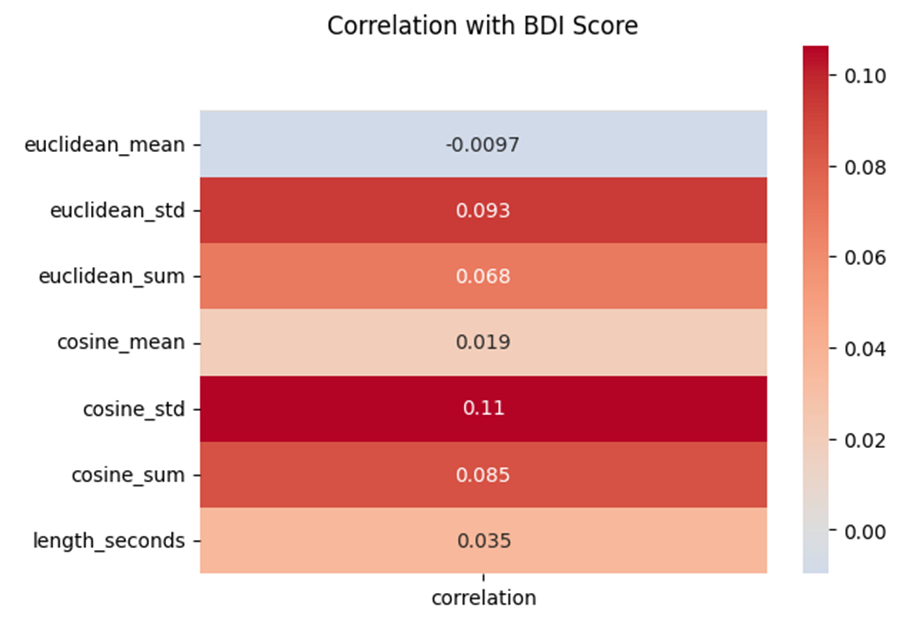

#7. scatter plot

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/data_with_linguistic_features.csv')
df

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# calculate cosine similarity between vectors
similarity_matrix = cosine_similarity(df.iloc[:, 13:])

# print the similarity matrix
similarity_matrix.shape

In [ ]:
# compare all the rows of the first and second column
# pic1 subj1 & pic2 subj1
import matplotlib.pyplot as plt
import numpy as np

# Generate a random similarity matrix

# Create a scatter plot matrix of the similarity matrix
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(similarity_matrix[:, 0], similarity_matrix[:, 1], s=1)
plt.show()


In [ ]:
# pic1 subj1 & pic1 subj2

import matplotlib.pyplot as plt
import numpy as np

# Create a scatter plot matrix of the similarity matrix
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(similarity_matrix[:, 0], similarity_matrix[:, 8], s=1)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# calculate cosine similarity between vectors
similarity_matrix = cosine_similarity(df.iloc[:, 13:])

# Perform PCA on the similarity matrix
pca = PCA(n_components=2)
pca.fit(similarity_matrix)
transformed_matrix = pca.transform(similarity_matrix)
third_variable = df.BDI_score
# third_variable = np.random.rand(952)

# Create a scatter plot of the first two principal components, with color based on the third variable
fig, ax = plt.subplots(figsize=(19, 8))
scatter = ax.scatter(transformed_matrix[:, 0], transformed_matrix[:, 1], c=third_variable, s=30, cmap='coolwarm', vmin=np.min(third_variable), vmax=np.max(third_variable))
plt.colorbar(scatter)

# Add labels and title to the plot
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('Scatter Plot with Color Based on BDI_score')

plt.show()

#8. unsupervised

In [ ]:
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from google.colab import drive
drive.mount('/content/gdrive')

# Load the dataset
df = pd.read_csv('/content/gdrive/MyDrive/final_data_with_linguistic_features.csv')

In [ ]:
# Extract features from the transcript column using TF-IDF vectorization
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['transcript'])

In [ ]:
# Cluster the text data
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

# Evaluate the clustering results
labels = kmeans.labels_
score = silhouette_score(X, labels)
print('Silhouette score:', score)

# Manually inspect the clusters
cluster1 = df[labels == 0]
cluster2 = df[labels == 1]
print('Cluster 1:', cluster1)
print('Cluster 2:', cluster2)

# Visualize the results
# TODO: Add code to visualize the results


To visualize the clustering results using all the columns of the TF-IDF matrix, you can use dimensionality reduction techniques such as principal component analysis (PCA) or t-distributed stochastic neighbor embedding (t-SNE) to project the high-dimensional data onto a lower-dimensional space that can be easily visualized.

In [ ]:
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Cluster the text data
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

# Reduce the dimensionality of the data using t-SNE
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X.toarray())

# Evaluate the clustering results
labels = kmeans.labels_
score = silhouette_score(X, labels)
print('Silhouette score:', score)

# Visualize the clustering results
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, s=50, cmap='viridis')
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
ax.add_artist(legend)
plt.title('Clustering Results')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce the dimensionality of the data using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Evaluate the clustering results
labels = kmeans.labels_
score = silhouette_score(X, labels)
print('Silhouette score:', score)

# Visualize the clustering results
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=50, cmap='viridis')
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
ax.add_artist(legend)
plt.title('Clustering Results')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


امتیاز سیلوئت یک معیار از جدایی خوب خوشه‌ها در نتیجه خوشه‌بندی است. این امتیاز از -1 تا 1 متغیر است، به طوری که امتیاز 1 نشان دهنده جدایی کامل خوشه‌ها، امتیاز 0 نشان دهنده همپوشانی خوشه‌ها و امتیاز -1 نشان دهنده این است که نمونه‌ها به خوشه‌های اشتباهی اختصاص داده شده‌اند.

در مورد ما امتیاز سیلوئت 0.005 نشان می‌دهد که خوشه‌ا بسیار نزدیک به هم و همپوشانی دارند، به این معنی که نتیجه خوشه‌بندی خوبی نیست. این امتیا نشان می‌دهد که الگوریتم خوشه‌بندی قادر به جداسازی ده‌ها به خوشه‌های مجزا نیست.


In [ ]:
# Cluster the text data
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

# Reduce the dimensionality of the data using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Evaluate the clustering results
labels = kmeans.labels_
score = silhouette_score(X, labels)
print('Silhouette score:', score)

# Visualize the clustering results
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=50, cmap='viridis')
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
ax.add_artist(legend)
plt.title('Clustering Results')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [ ]:
# Cluster the text data
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)

# Reduce the dimensionality of the data using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Evaluate the clustering results
labels = kmeans.labels_
score = silhouette_score(X, labels)
print('Silhouette score:', score)

# Visualize the clustering results
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=50, cmap='viridis', alpha=0.5)
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
ax.add_artist(legend)
plt.title('Clustering Results')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# Perform hierarchical clustering on the data
Z = linkage(X.toarray(), method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()


# 9. feature extraction


##sentiment analysis

In [ ]:
import pandas as pd

from google.colab import drive
drive.mount('/content/gdrive')

df = pd.read_csv('/content/gdrive/MyDrive/final_data_with_linguistic_features.csv')

In [ ]:
import pandas as pd
from transformers import pipeline

# Load the sentiment analysis model
classifier = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')

# Define a function to extract sentiment from text
def get_sentiment(text):
    result = classifier(text)[0]
    sentiment_score = result['score']
    return sentiment_score

# Apply the function to the text column and create a new column for sentiment
df['sentiment_transformers'] = df['transcript'].apply(get_sentiment)

In [ ]:
!pip install hazm
#then restart run time

In [ ]:
!pip install flair

In [ ]:
import pandas as pd
from hazm import sent_tokenize, word_tokenize, Normalizer
from flair.models import TextClassifier
from flair.data import Sentence

# Initialize the Hazm library tools and the Flair sentiment classifier
normalizer = Normalizer()
classifier = TextClassifier.load('sentiment')

# Define a function to extract sentiment from text
def get_sentiment(text):
    normalized_text = normalizer.normalize(text)
    sentences = sent_tokenize(normalized_text)
    sentiment_scores = []
    for sentence in sentences:
        sentence = Sentence(sentence)
        classifier.predict(sentence)
        sentiment_scores.append(sentence.labels[0].score)
    sentiment_score = sum(sentiment_scores) / len(sentiment_scores)
    return sentiment_score

# Apply the function to the text column and create a new column for sentiment
df['sentiment_flair'] = df['transcript'].apply(get_sentiment)

##Speeh Graph Analysis

WC/
nodes/
edges/
RE/
PE/
L1/
L2/
L3/
LCC/
LSC_/
ATD_list/density/
diameter/
CC/

In [ ]:
import networkx as nx
import pandas as pd
import hazm # for Persian text processing

# Create empty lists to store graph attributes
WC_list = []
nodes_list = []
edges_list = []
RE_list = []
PE_list = []
L1_list = []
L2_list = []
L3_list = []
LCC_list = []
LSC_list = []
ATD_list =density_list = []
diameter_list = []
ASP_list = []
CC_list = []

# Iterate over the rows of the dataset
for index, row in df.iterrows():
    # Tokenize the Persian text using Hazm
    tokens = hazm.word_tokenize(row['transcript'])
    # Create an undirected graph from the tokens
    G = nx.Graph()
    for token in tokens:
        G.add_node(token)
    for i in range(len(tokens)-1):
        G.add_edge(tokens[i], tokens[i+1])
    # Calculate graph attributes
    WC = len(tokens)
    nodes = len(G.nodes())
    edges = len(G.edges())
    RE = edges / nodes
    PE = edges / (nodes * (nodes - 1))
    L1 = nx.average_shortest_path_length(G)
    L2 = nx.algebraic_connectivity(G)
    # L3 = nx.spectral_radius(G)
    LCC = nx.average_clustering(G)
    LSC = nx.average_shortest_path_length(nx.line_graph(G))
    # ATD = nx.average_degree_connectivity(G)
    density = nx.density(G)
    diameter = nx.diameter(G)
    ASP = nx.average_shortest_path_length(G)
    CC = nx.transitivity(G)
    # Append graph attributes to lists
    WC_list.append(WC)
    nodes_list.append(nodes)
    edges_list.append(edges)
    RE_list.append(RE)
    PE_list.append(PE)
    L1_list.append(L1)
    L2_list.append(L2)
    # L3_list.append(L3)
    LCC_list.append(LCC)
    LSC_list.append(LSC)
    # ATD_list.append(ATD)
    density_list.append(density)
    diameter_list.append(diameter)
    ASP_list.append(ASP)
    CC_list.append(CC)

# Add graph attributes as columns to the DataFrame
df['WC'] = WC_list
df['nodes'] = nodes_list
df['edges'] = edges_list
df['RE'] = RE_list
df['PE'] = PE_list
df['L1'] = L1_list
df['L2'] = L2_list
# df['L3'] = L3_list
df['LCC'] = LCC_list
df['LSC'] = LSC_list
# df['ATD'] = ATD_list
df['density'] = density_list
df['diameter'] = diameter_list
df['ASP'] = ASP_list
df['CC'] = CC_list


In [ ]:
# Save the updated DataFrame to a CSV file
df.to_csv('/content/gdrive/MyDrive/persian_dataset_with_graph_attributes_sentiment_jumping.csv', index=False)

##correlation

In [ ]:
df.columns

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot for repetitions and word_rate
plt.figure(figsize=(8, 6))
plt.scatter(df['sentiment_flair'],df['sentiment_transformers'], c=df['BDI_score'], cmap='coolwarm', alpha=0.8)
plt.colorbar(label='BDI Score')
plt.xlabel('sentiment_flair')
plt.ylabel('sentiment_transformers')
plt.title('Scatter Plot of sentiment_flair vs. sentiment_transformers')
#  The cmap parameter is used to specify the color map for the BDI scores.
plt.show()


In [ ]:
# correlation_df = pd.DataFrame()

import pandas as pd
import numpy as np

# calculate the correlation between each feature and the label
corr = df.drop(['category_numeric', 'file_name', 'transcript', 'id', 'TimeStamp','category', 'lengthBySeconds', 'length', 'total_length',
       'euclidean_mean', 'euclidean_std', 'euclidean_sum', 'cosine_mean',
       'cosine_std', 'cosine_sum',], axis=1).corr()['BDI_score']

# create a new dataframe with the correlation values
corr_df = pd.DataFrame({'correlation': corr})

# set the index to the feature names
corr_df.index = corr_df.index.str.replace('feature', 'feat')

# print the resulting dataframe
print(corr_df)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(corr_df[1:], annot=True, cmap='coolwarm', center=0)
plt.title('Correlation with BDI Score')
plt.show()

In [ ]:
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Convert y_train to a NumPy array
# y_train_np = y_train.cpu().detach().numpy()

# # Truncate the feature array to match the number of samples in the target array
# features_truncated = features[:target.shape[0]]

# # Concatenate the truncated feature array and the target array
# data = np.concatenate((features_truncated, target), axis=1)

# # Calculate the correlations
# correlations = np.corrcoef(data, rowvar=False)

# # Get the first three correlation values and their corresponding feature names
# correlation_values = correlations[-1, :-1][:3]
# feature_names = feature_names[:3]

# # Create a DataFrame with feature names and their correlations with BDI score
# correlation_df = pd.DataFrame(correlation_values, index=feature_names, columns=['Correlation with BDI Score'])

# # Print the correlation table
# print(correlation_df)

# # Create a heatmap of the correlations
# sns.heatmap(correlation_df, annot=True, cmap='coolwarm', center=0)
# plt.title('Correlation with BDI Score')
# plt.show()


# 10. SVM - RF- DT - balance - LOO

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd
data = pd.read_csv('/content/gdrive/MyDrive/persian_dataset_with_graph_attributes_sentiment_jumping.csv')

## TFIDF with 2 class

In [ ]:
!pip install transformers
from transformers import AutoTokenizer, AutoModel

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import torch
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from torch import nn

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# bdi<14 is normal and >14 is depress
label14 =[]
for i in range(data.shape[0]):
  if data.iloc[i]['BDI_score'] < 14:
    # print(data.iloc[i]['BDI_score'] , '//' ,data.iloc[i]['label9'])
    label14.append(0)
  else :
    label14.append(1)

data['label14'] = label14

y = data['label14']

In [ ]:
# bdi<9 is normal and >9 is depress
label9 =[]
for i in range(data.shape[0]):
  if data.iloc[i]['BDI_score'] < 9:
    # print(data.iloc[i]['BDI_score'] , '//' ,data.iloc[i]['label9'])
    label9.append(0)
  else :
    label9.append(1)

data['label9'] = label9

y = data['label9']

In [ ]:
data.columns

In [ ]:
data

In [ ]:
# Drop columns that are not needed for prediction
data = data.drop(['file_name','id', 'TimeStamp', 'category', 'total_length','lengthBySeconds'], axis=1)

# Convert 'category_numeric' column to numeric values
data['category_numeric'] = pd.to_numeric(data['category_numeric'], errors='coerce')

# Preprocess the 'length' column to convert it into a numeric format (seconds)
def convert_length_to_seconds(length):
    parts = length.split('.')
    if len(parts) == 3:
        # HH.MM.SS format
        hours = int(parts[0])
        minutes = int(parts[1])
        seconds = int(parts[2])
    else:
        raise ValueError(f"Invalid time format: {length}")
    return hours * 3600 + minutes * 60 + seconds

data['length_seconds'] = data['length'].apply(convert_length_to_seconds)

# Split the dataset into features (X) and target variable (y)
X = data[['transcript','euclidean_mean', 'euclidean_std', 'euclidean_sum', 'cosine_mean',
       'cosine_std', 'cosine_sum', 'sentiment_transformers', 'sentiment_flair',
       'WC', 'nodes', 'edges', 'RE', 'PE', 'L1', 'L2', 'LCC', 'LSC', 'density',
       'diameter', 'ASP', 'CC', 'length_seconds' ]]
# y = data['BDI_score']

In [ ]:
plt.hist(data['BDI_score'])

In [ ]:
plt.hist(y)

In [ ]:
# Extract features from the transcript column using TF-IDF vectorization
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X['transcript'])
X_tfidf.shape

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
pca.fit(X_tfidf.toarray())

In [ ]:
from sklearn.decomposition import PCA
# from sklearn.datasets import load_iris



# Plot scree plot
import matplotlib.pyplot as plt
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()


so 7 is The "elbow" point

In [ ]:
from sklearn.decomposition import PCA

# Assuming tfidf_matrix is your TF-IDF matrix
pca = PCA(n_components=7) # You can choose the number of components you want to reduce to
pca.fit(X_tfidf.toarray())

# Transform the matrix
tfidf_pca = pca.transform(X_tfidf.toarray())

# Print the shape of the new matrix
print(tfidf_pca.shape)

In [ ]:
X.columns

In [ ]:
# Scale the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.drop(['transcript', 'length_seconds'], axis=1))

# Concatenate the TF-IDF features with the scaled numerical features
X_final = np.concatenate((tfidf_pca, X_scaled), axis=1)

In [ ]:
# Drop rows with missing values from the training data
mask = ~np.isnan(X_final).any(axis=1)
X_final = X_final[mask]
y = y[mask]

In [ ]:
X_final.shape

In [ ]:
# Convert the NumPy arrays to PyTorch tensors and move them to the GPU
X_final = torch.tensor(X_final, dtype=torch.float32).to(device)
y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1).to(device)

In [ ]:
X_final.shape

In [ ]:
#tfidf_pca & jumping & SGA & sentiment
# LOO
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score

X= X_final
y= y

loo = LeaveOneOut()
mse_list = []
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
y_pred_list = []
y_test_list= []

for train_index, test_index in loo.split(X):


    # print(loo.split(X) , '/' ,train_index , '/' ,test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = SVC(kernel='linear')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    y_pred_list.append(y_pred)
    y_test_list.append(y_test)
    mse_list.append(mse)
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

In [ ]:
mean_mse = sum(mse_list) / len(mse_list)
mean_accuracy = sum(accuracy_list) / len(accuracy_list)
mean_precision = sum(precision_list) / len(precision_list)
mean_recall = sum(recall_list) / len(recall_list)
mean_f1 = sum(f1_list) / len(f1_list)

print("Mean MSE:", mean_mse)
print("Mean accuracy:", mean_accuracy)
print("Mean precision:", mean_precision)
print("Mean recall:", mean_recall)
print("Mean F1 score:", mean_f1);

# goalllll
# Mean MSE: 0.416195856873823
# Mean accuracy: 0.583804143126177
# Mean precision: 0.583804143126177
# Mean recall: 0.583804143126177
# Mean F1 score: 0.583804143126177

#label14
# Mean MSE: 0.4218455743879473
# Mean accuracy: 0.5781544256120528
# Mean precision: 0.5781544256120528
# Mean recall: 0.5781544256120528
# Mean F1 score: 0.5781544256120528

In [ ]:
from tabulate import tabulate

# Create a table comparing actual and predicted scores
comparison_table = pd.DataFrame({'Actual BDI Score': y_test_list, 'Predicted BDI Score': y_pred_list})
table = tabulate(comparison_table, headers='keys', tablefmt='psql')
print(table)


In [ ]:
# convert tensor to list
y_true_converted = []
for elem in y_test_list:
    y_true_converted.append(int(elem[0].item()))

# print(y_true_converted)

1. Confusion Matrix:

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Obtain the predictions from your classification model
y_pred = y_pred_list

# Obtain the true labels for the test data
y_true = y_true_converted

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class names and colormap
classes = ['Class 0', 'Class 1']
cmap = plt.cm.Blues

# Normalize the confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_norm, annot=cm, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


2. ROC Curve:

The ROC (Receiver Operating Characteristic) curve is a graphical representation of the performance of a binary classification model. It plots the true positive rate (sensitivity) against the false positive rate (1-specificity) at various thresholds.

An ideal ROC curve should have a steep upward slope and then a sharp turn toward the upper-left corner, followed by a gentle flattening out toward the top-right corner. This means that the model has high sensitivity (true positive rate) and low false positive rate across all possible threshold values, indicating that it is able to accurately distinguish between positive and negative cases. In other words, an ideal ROC curve would have an AUC (Area Under the Curve) value of 1.0, which represents perfect predictive ability.

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Obtain the predicted probabilities from your classification model
y_scores = y_pred_list

# Obtain the true labels for the test data
y_true = y_true_converted

# Compute the false positive rate, true positive rate, and threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


3. Precision-Recall Curve:

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt


# Compute the precision, recall, and threshold values
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Plot the precision-recall curve
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


##Scatter Plot between features:


In [ ]:
# Move the tensors to CPU memory
X_train_final_cpu = X_train_final.cpu()
y_train_cpu = y_train.cpu()

# Scatter plot for repetitions and word_rate
plt.figure(figsize=(8, 6))
plt.scatter(X_train_final_cpu[:, 0].numpy(), X_train_final_cpu[:, 1].numpy(), c=y_train_cpu.squeeze(), cmap='coolwarm', alpha=0.8)
plt.colorbar(label='BDI Score')
plt.xlabel('Number of Words')
plt.ylabel('Repetitions')
plt.title('Scatter Plot of Number of Words vs. Repetitions')
#  The cmap parameter is used to specify the color map for the BDI scores.
plt.show()


In [ ]:
# Move the tensors to CPU memory
X_train_final_cpu = X_train_final.cpu()
y_train_cpu = y_train.cpu()

# Scatter plot for Repetitions and word_rate
plt.figure(figsize=(8, 6))
plt.scatter(X_train_final_cpu[:, 1].numpy(), X_train_final_cpu[:,2].numpy(), c=y_train_cpu.squeeze(), cmap='coolwarm', alpha=0.8)
plt.colorbar(label='BDI Score')
plt.xlabel('Repetitions')
plt.ylabel('Word Rate')
plt.title('Scatter Plot of Repetitions vs. Word Rate')
#  The cmap parameter is used to specify the color map for the BDI scores.
plt.show()

In [ ]:
# Move the tensors to CPU memory
X_train_final_cpu = X_train_final.cpu()
y_train_cpu = y_train.cpu()

# Scatter plot for Number of Words and word_rate
plt.figure(figsize=(8, 6))
plt.scatter(X_train_final_cpu[:, 0].numpy(), X_train_final_cpu[:,2].numpy(), c=y_train_cpu.squeeze(), cmap='coolwarm', alpha=0.8)
plt.colorbar(label='BDI Score')
plt.xlabel('Number of Words')
plt.ylabel('Word Rate')
plt.title('Scatter Plot of Number of Words vs. Word Rate')
#  The cmap parameter is used to specify the color map for the BDI scores.
plt.show()

In [ ]:
# Move the tensors to CPU memory
X_train_final_cpu = X_train_final.cpu()
y_train_cpu = y_train.cpu()

# Scatter plot for
plt.figure(figsize=(8, 6))
plt.scatter(X_train_final_cpu[:, 6].numpy(), X_train_final_cpu[:,8].numpy(), c=y_train_cpu.squeeze(), cmap='coolwarm', alpha=0.8)
plt.colorbar(label='BDI Score')
plt.xlabel('cosine mean')
plt.ylabel('cosine sum')
plt.title('Scatter Plot of cosine mean vs. cosine sum')
#  The cmap parameter is used to specify the color map for the BDI scores.
plt.show()

In [ ]:
# # Move the tensors to CPU memory
# X_train_final_cpu = X_train_final.cpu()
# y_train_cpu = y_train.cpu()

# # Scatter plot
# plt.figure(figsize=(8, 6))
# plt.scatter(X_train_final_cpu[:, 0].numpy(), X_train_final_cpu[:,5].numpy(), c=y_train_cpu.squeeze(), cmap='coolwarm', alpha=0.8)
# plt.colorbar(label='BDI Score')
# plt.xlabel('Number of Words')
# plt.ylabel('total length')
# plt.title('Scatter Plot of Number of Words vs. total length')
# #  The cmap parameter is used to specify the color map for the BDI scores.
# plt.show()

### size

In [ ]:
# Move the tensors to CPU memory
X_train_final_cpu = X_train_final.cpu()
y_train_cpu = y_train.cpu()

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(X_train_final_cpu[:, 1].numpy(), X_train_final_cpu[:,2].numpy(), c=y_train_cpu.squeeze(),s=y_train_cpu.squeeze() , cmap='coolwarm', alpha=0.8)
plt.colorbar(label='BDI Score')
plt.xlabel('repetition')
plt.ylabel('word rate')
plt.title('Scatter Plot of repetition vs. word rate')
#  The cmap parameter is used to specify the color map for the BDI scores.
plt.show()

# TFIDF with 63 class _ balance

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import torch
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
# from transformers import AutoTokenizer, AutoModel
from torch import nn

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
data = pd.read_csv('/content/gdrive/MyDrive/persian_dataset_with_graph_attributes_sentiment_jumping.csv')

### balanced data before dropna

In [ ]:
import pandas as pd
import numpy as np

# Load your dataframe into a pandas DataFrame object
df1 =data

# Define the bins for the 'bdi' column
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]

# Use pandas cut function to bin the 'bdi' values into different ranges
df1['bdi_range'] = pd.cut(df1['BDI_score'], bins=bins)

# Count the number of rows falling in each range
count = df1.groupby('bdi_range')['BDI_score'].count()

# Identify the ranges with large values
large_ranges = count[count > 16].index.tolist()

# Randomly delete half of the rows in the large ranges
for r in large_ranges:
    # print(r)
    rows_to_delete = df1[df1['bdi_range'] == r].sample(n= len(df1[df1['bdi_range'] == r]) - 16 ).index
    # rows_to_delete = np.random.choice(df1.index, size=16, replace=False)
    df1.drop(rows_to_delete, inplace=True)

data= df1
data = data.reset_index().drop(['index'],axis=1)

In [ ]:
rows_to_delete = df1[df1['bdi_range'] == count[count > 16].index.tolist()[0]].sample(n=  16 ).index
# rows_to_delete = np.random.choice(df1.index, size=16, replace=False)
df1.drop(rows_to_delete, inplace=True)

In [ ]:
plt.hist(df1['BDI_score'])

### continue...

In [ ]:
# # Drop columns that are not needed for prediction
data = data.drop(['file_name','id', 'TimeStamp', 'category', 'total_length','lengthBySeconds'], axis=1)
# data=df1

# Convert 'category_numeric' column to numeric values
data['category_numeric'] = pd.to_numeric(data['category_numeric'], errors='coerce')

# Preprocess the 'length' column to convert it into a numeric format (seconds)
def convert_length_to_seconds(length):
    parts = length.split('.')
    if len(parts) == 3:
        # HH.MM.SS format
        hours = int(parts[0])
        minutes = int(parts[1])
        seconds = int(parts[2])
    else:
        raise ValueError(f"Invalid time format: {length}")
    return hours * 3600 + minutes * 60 + seconds

data['length_seconds'] = data['length'].apply(convert_length_to_seconds)



# Split the dataset into features (X) and target variable (y)
X = data[['transcript','euclidean_mean', 'euclidean_std', 'euclidean_sum', 'cosine_mean',
       'cosine_std', 'cosine_sum', 'sentiment_transformers', 'sentiment_flair',
       'WC', 'nodes', 'edges', 'RE', 'PE', 'L1', 'L2', 'LCC', 'LSC', 'density',
       'diameter', 'ASP', 'CC', 'length_seconds' ]]
y = data['BDI_score']

In [ ]:
plt.hist(y)

In [ ]:
# Extract features from the transcript column using TF-IDF vectorization
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X['transcript'])
X_tfidf.shape

In [ ]:
from sklearn.decomposition import PCA

# Assuming tfidf_matrix is your TF-IDF matrix
pca = PCA(n_components=7) # You can choose the number of components you want to reduce to
pca.fit(X_tfidf.toarray())

# Transform the matrix
tfidf_pca = pca.transform(X_tfidf.toarray())

# Print the shape of the new matrix
print(tfidf_pca.shape)

In [ ]:
# Scale the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.drop(['transcript', 'length_seconds'], axis=1))

# Concatenate the TF-IDF features with the scaled numerical features
X_final = np.concatenate((tfidf_pca, X_scaled), axis=1)

In [ ]:
# Drop rows with missing values from the training data
mask = ~np.isnan(X_final).any(axis=1)
X_final = X_final[mask]
y = y[mask]

In [ ]:
# Convert the NumPy arrays to PyTorch tensors and move them to the GPU
X_final = torch.tensor(X_final, dtype=torch.float32).to(device)
y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1).to(device)

###continue

In [ ]:
#tfidf_pca & jumping & SGA & sentiment
# LOO
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score

X= X_final
y= y

loo = LeaveOneOut()
mse_list = []
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
y_pred_list = []
y_test_list= []

for train_index, test_index in loo.split(X):


    # print(loo.split(X) , '/' ,train_index , '/' ,test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = SVC(kernel='linear')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    y_pred_list.append(y_pred)
    y_test_list.append(y_test)
    mse_list.append(mse)
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

In [ ]:
mean_mse = sum(mse_list) / len(mse_list)
mean_accuracy = sum(accuracy_list) / len(accuracy_list)
mean_precision = sum(precision_list) / len(precision_list)
mean_recall = sum(recall_list) / len(recall_list)
mean_f1 = sum(f1_list) / len(f1_list)

print("Mean MSE:", mean_mse)
print("Mean accuracy:", mean_accuracy)
print("Mean precision:", mean_precision)
print("Mean recall:", mean_recall)
print("Mean F1 score:", mean_f1);

# label9:
# Mean MSE: 532.8807339449542
# Mean accuracy: 0.1743119266055046
# Mean precision: 0.1743119266055046
# Mean recall: 0.1743119266055046
# Mean F1 score: 0.1743119266055046

# label14
# Mean MSE: 381.71844660194176
# Mean accuracy: 0.23300970873786409
# Mean precision: 0.23300970873786409
# Mean recall: 0.23300970873786409
# Mean F1 score: 0.23300970873786409

In [ ]:
from tabulate import tabulate

# Create a table comparing actual and predicted scores
comparison_table = pd.DataFrame({'Actual BDI Score': y_test_list, 'Predicted BDI Score': y_pred_list})
table = tabulate(comparison_table, headers='keys', tablefmt='psql')
print(table)


In [ ]:
# convert tensor to list
y_true_converted = []
for elem in y_test_list:
    y_true_converted.append(int(elem[0].item()))

# print(y_true_converted)

modify the size and color an size of the points based on Length

In [ ]:
import matplotlib.pyplot as plt

y_test_series = np.array(y_test_list)
subset_data = data.loc[pd.DataFrame(y_test_list).index]

# Plot actual and predicted scores with size variation
plt.scatter(y_test_series, y_pred_list,  alpha=0.5 ,s=subset_data['length_seconds'],c=subset_data['length_seconds']) #s=subset_data['length_seconds']/60
plt.plot([min(y_test_series), max(y_test_series)], [min(y_test_series), max(y_test_series)], color='red', linestyle='--')
plt.colorbar(label='length_seconds')
plt.xlabel('Actual BDI Score')
plt.ylabel('Predicted BDI Score')
plt.title('Actual vs Predicted BDI Score with Size Variation, size:length_seconds')
plt.show();


Residual Plot:
This plot shows the residuals (the differences between the actual and predicted values) against the predicted values. It helps to identify any patterns or trends in the residuals, which can provide insights into the model's performance.

Distribution of Residuals:
This histogram shows the distribution of the residuals. It helps to check if the residuals follow a normal distribution, which is desired for a well-performing model.

In [ ]:
residuals =  y_true_converted -  np.array(y_pred_list)

plt.hist(residuals, bins=20, alpha=0.5)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()


#visualized similarity matrix

In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/finaldata_with_vectors.csv')
vectors= data.iloc[:, -768:]
vectors

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# calculate cosine similarity between vectors
similarity_matrix = cosine_similarity(vectors)

# print the similarity matrix
similarity_matrix.shape

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# calculate cosine similarity between vectors
similarity_matrix = cosine_similarity(vectors)

# create a heatmap of the similarity matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(similarity_matrix, cmap='coolwarm')

# rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")

# set the x and y ticks every 80 rows and columns
ax.set_xticks(np.arange(0, 952, 80))
ax.set_yticks(np.arange(0, 952, 80))

# add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set the title and show the plot
ax.set_title("Similarity Matrix")
fig.tight_layout()
plt.show()


## sort images after sm

In [ ]:
import numpy as np

# generate the selected_rows arrays using a list comprehension
selected_rows = [np.arange(i, similarity_matrix.shape[0], 8) for i in range(8)]
# print the selected_rows arrays
for i, rows in enumerate(selected_rows):
    selected_rows[i]=rows

# generate the selected_cols arrays using a list comprehension
selected_cols = [np.arange(i, similarity_matrix.shape[0], 8) for i in range(8)]
# print the selected_cols arrays
for i, cols in enumerate(selected_cols):
    selected_cols[i]=cols

# generate the selected_matrix arrays using nested list comprehensions
# print('selected_rows:',selected_rows)
# print('selected_cols:',selected_cols)
selected_matrix = [[similarity_matrix[rows][:, cols] for cols in selected_cols] for rows in selected_rows]
# concatenate the selected_matrix arrays into a single DataFrame
selected_matrix_df = pd.concat([pd.DataFrame(np.hstack(m)) for m in selected_matrix])
# print( 'selected_matrix_df.shape:', selected_matrix_df.shape)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = selected_matrix_df

# create a figure and axis object
fig, ax = plt.subplots(figsize=(8, 6))

# plot the DataFrame
im = ax.imshow(df, cmap='coolwarm')

# set the x and y ticks and labels
for i in range(8):
    ax.axhline((i+1)*119-0.5, color='black', linewidth=0.8)
    ax.axvline((i+1)*119-0.5, color='black', linewidth=0.8)
    ax.text((i+0.5)*119, -50, f'pic{i+1}', ha='center', fontsize=10)
    ax.text(-100, (i+0.5)*119, f'pic{i+1}', va='center', fontsize=10)

# remove the x and y ticks
ax.set_xticks([])
ax.set_yticks([])

# add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set the title below the figure
fig.suptitle('Similarity Matrix sort by pictures', fontsize=16, y=0.05, va='center')


# show the plot
plt.show()

# sort by images and BDI-score

In [ ]:
import pandas as pd
import numpy as np

# Create a sample DataFrame with shape 952 x 799 and random scores
df = data

# Define the indices of the groups of rows in the desired order - for images sorting
group_indices = [[i+j for i in range(0, 952, 8)] for j in range(8)]

# Sort each group of rows based on the "score" column separately - for feature sorting
sorted_groups = []
for group in group_indices:
    sorted_group = df.iloc[group].sort_values('BDI_score')
    sorted_groups.append(sorted_group)

# Concatenate the sorted groups and the remaining unsorted rows
sorted_df_by_images_and_BDI = pd.concat(sorted_groups + [df.drop(sum(group_indices, []))])

# Display the sorted DataFrame
print(sorted_df_by_images_and_BDI)


##compute SM

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# calculate cosine similarity between vectors
similarity_matrix = cosine_similarity(sorted_df_by_images_and_BDI.iloc[:, -768:])

# print the similarity matrix
print( 'sorted_df.shape:', sorted_df_by_images_and_BDI.shape,'similarity_matrix.shape:',similarity_matrix.shape)

In [ ]:
import matplotlib.pyplot as plt

# create a heatmap of the similarity matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(similarity_matrix,cmap='coolwarm')

# rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")

# set the x and y ticks every 80 rows and columns
ax.set_xticks(np.arange(0, 952, 119))
ax.set_yticks(np.arange(0, 952, 119))

# add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set the title and show the plot
ax.set_title("Similarity Matrix sort by images and BDI on them")
fig.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# create a figure and axis object
fig, ax = plt.subplots(figsize=(8, 6))

# plot the DataFrame
im = ax.imshow(similarity_matrix, cmap='coolwarm')

# set the x and y ticks and labels
for i in range(8):
    ax.axhline((i+1)*119-0.5, color='black', linewidth=0.8)
    ax.axvline((i+1)*119-0.5, color='black', linewidth=0.8)
    ax.text((i+0.5)*119, -50, f'pic{i+1}', ha='center', fontsize=10)
    ax.text(-100, (i+0.5)*119, f'pic{i+1}', va='center', fontsize=10)

# remove the x and y ticks
ax.set_xticks([])
ax.set_yticks([])

# add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set the title below the figure
fig.suptitle('Similarity Matrix sort by pictures and BDI', fontsize=16, y=0.05, va='center')


# show the plot
plt.show()

## percentile - use MS

In [ ]:
import numpy as np
from scipy.stats import rankdata

# assume sim_matrix is your similarity matrix
n_items = similarity_matrix.shape[0]

# flatten the similarity matrix and compute ranks
ranks = rankdata(similarity_matrix.flatten())

# reshape the ranks back into the original matrix shape
ranks_matrix = ranks.reshape((n_items, n_items))

# compute percentiles by dividing ranks by total number of scores and multiplying by 100
percentile_matrix = (ranks_matrix / len(ranks)) * 100

# print the resulting percentile matrix
percentile_matrix


In [ ]:
import matplotlib.pyplot as plt

# create a heatmap of the similarity matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(percentile_matrix,cmap='inferno')

# rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")

# set the x and y ticks every 80 rows and columns
ax.set_xticks(np.arange(0, 952, 119))
ax.set_yticks(np.arange(0, 952, 119))

# add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set the title and show the plot
ax.set_title("equalized Similarity Matrix sort by images and BDI on them")
fig.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# create a figure and axis object
fig, ax = plt.subplots(figsize=(8, 6))

# plot the DataFrame
im = ax.imshow(percentile_matrix, cmap='inferno')

# set the x and y ticks and labels
for i in range(8):
    ax.axhline((i+1)*119-0.5, color='black', linewidth=0.8)
    ax.axvline((i+1)*119-0.5, color='black', linewidth=0.8)
    ax.text((i+0.5)*119, -50, f'pic{i+1}', ha='center', fontsize=10)
    ax.text(-100, (i+0.5)*119, f'pic{i+1}', va='center', fontsize=10)

# remove the x and y ticks
ax.set_xticks([])
ax.set_yticks([])

# add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set the title below the figure
fig.suptitle('equalized Similarity Matrix sort by pictures and BDI on them', fontsize=16, y=0.05, va='center')


# show the plot
plt.show()

In [ ]:
# # select the first 500 rows and columns of the similarity matrix
# subset1 = percentile_matrix[:119, :119]

# # select the last 500 rows and columns of the similarity matrix
# subset2 = percentile_matrix[:119, 119:238]

# # calculate the mean similarity of each subset
# mean1 = np.mean(subset1)
# mean2 = np.mean(subset2)

# # print the mean similarity of each subset
# print("Mean similarity of subset 1:", mean1)
# print("Mean similarity of subset 2:", mean2)

## sub plots

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create a random matrix with shape (952, 952)
matrix = percentile_matrix

# Define the sub-matrix size
sub_size = 119

# Iterate over the matrix in steps of sub_size
for i in range(0, matrix.shape[0], sub_size):
    for j in range(0, matrix.shape[1], sub_size):
        # Extract the sub-matrix
        sub_matrix = matrix[i:i+sub_size, j:j+sub_size]

        # Plot the sub-matrix
        plt.imshow(sub_matrix, cmap="inferno")

        # Add a title to the plot
        plt.title(f"Sub-matrix ({int(i/119 )+1},{int(j/119)+1})")

        # Show the plot
        plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create a random matrix with shape (952, 952)
matrix = percentile_matrix

# Define the sub-matrix size
sub_sizei = 119
sub_sizej = 952

# Iterate over the matrix in steps of sub_size
for i in range(0, matrix.shape[0], sub_sizei):
    for j in range(0, matrix.shape[1], sub_sizej):
        # Extract the sub-matrix
        sub_matrix = matrix[i:i+sub_sizei, j:j+sub_sizej]

        # Plot the sub-matrix
        plt.imshow(sub_matrix, cmap="inferno")

        # Add a title to the plot
        plt.title(f"Sub-matrix ({int(i/119 )+1},all)")

        # Show the plot
        plt.show()


In [ ]:
data.columns[:31]

In [ ]:
import pandas as pd
import numpy as np

# Create a sample DataFrame with shape 952 x 799 and random scores
df = data

# Define the indices of the groups of rows in the desired order - for images sorting
group_indices = [[i+j for i in range(0, 952, 8)] for j in range(8)]

# Sort each group of rows based on the "score" column separately - for feature sorting
sorted_groups = []
for group in group_indices:
    sorted_group = df.iloc[group].sort_values('BDI_score')
    sorted_groups.append(sorted_group)

# Concatenate the sorted groups and the remaining unsorted rows
sorted_df_by_images_and_BDI = pd.concat(sorted_groups + [df.drop(sum(group_indices, []))])

# Display the sorted DataFrame
print(sorted_df_by_images_and_BDI)


##compute SM

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# calculate cosine similarity between vectors
similarity_matrix = cosine_similarity(sorted_df_by_images_and_BDI.iloc[:, -768:])

# print the similarity matrix
print( 'sorted_df.shape:', sorted_df_by_images_and_BDI.shape,'similarity_matrix.shape:',similarity_matrix.shape)

In [ ]:
import matplotlib.pyplot as plt

# create a heatmap of the similarity matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(similarity_matrix,cmap='coolwarm')

# rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")

# set the x and y ticks every 80 rows and columns
ax.set_xticks(np.arange(0, 952, 119))
ax.set_yticks(np.arange(0, 952, 119))

# add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set the title and show the plot
ax.set_title("Similarity Matrix sort by images and BDI on them")
fig.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# create a figure and axis object
fig, ax = plt.subplots(figsize=(8, 6))

# plot the DataFrame
im = ax.imshow(similarity_matrix, cmap='coolwarm')

# set the x and y ticks and labels
for i in range(8):
    ax.axhline((i+1)*119-0.5, color='black', linewidth=0.8)
    ax.axvline((i+1)*119-0.5, color='black', linewidth=0.8)
    ax.text((i+0.5)*119, -50, f'pic{i+1}', ha='center', fontsize=10)
    ax.text(-100, (i+0.5)*119, f'pic{i+1}', va='center', fontsize=10)

# remove the x and y ticks
ax.set_xticks([])
ax.set_yticks([])

# add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set the title below the figure
fig.suptitle('Similarity Matrix sort by pictures and BDI', fontsize=16, y=0.05, va='center')


# show the plot
plt.show()

## percentile - use MS

In [ ]:
import numpy as np
from scipy.stats import rankdata

# assume sim_matrix is your similarity matrix
n_items = similarity_matrix.shape[0]

# flatten the similarity matrix and compute ranks
ranks = rankdata(similarity_matrix.flatten())

# reshape the ranks back into the original matrix shape
ranks_matrix = ranks.reshape((n_items, n_items))

# compute percentiles by dividing ranks by total number of scores and multiplying by 100
percentile_matrix = (ranks_matrix / len(ranks)) * 100

# print the resulting percentile matrix
percentile_matrix


In [ ]:
import matplotlib.pyplot as plt

# create a heatmap of the similarity matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(percentile_matrix,cmap='inferno')

# rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")

# set the x and y ticks every 80 rows and columns
ax.set_xticks(np.arange(0, 952, 119))
ax.set_yticks(np.arange(0, 952, 119))

# add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set the title and show the plot
ax.set_title("equalized Similarity Matrix sort by images and BDI on them")
fig.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# create a figure and axis object
fig, ax = plt.subplots(figsize=(8, 6))

# plot the DataFrame
im = ax.imshow(percentile_matrix, cmap='inferno')

# set the x and y ticks and labels
for i in range(8):
    ax.axhline((i+1)*119-0.5, color='black', linewidth=0.8)
    ax.axvline((i+1)*119-0.5, color='black', linewidth=0.8)
    ax.text((i+0.5)*119, -50, f'pic{i+1}', ha='center', fontsize=10)
    ax.text(-100, (i+0.5)*119, f'pic{i+1}', va='center', fontsize=10)

# remove the x and y ticks
ax.set_xticks([])
ax.set_yticks([])

# add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set the title below the figure
fig.suptitle('equalized Similarity Matrix sort by pictures and BDI on them', fontsize=16, y=0.05, va='center')


# show the plot
plt.show()

In [ ]:
# # select the first 500 rows and columns of the similarity matrix
# subset1 = percentile_matrix[:119, :119]

# # select the last 500 rows and columns of the similarity matrix
# subset2 = percentile_matrix[:119, 119:238]

# # calculate the mean similarity of each subset
# mean1 = np.mean(subset1)
# mean2 = np.mean(subset2)

# # print the mean similarity of each subset
# print("Mean similarity of subset 1:", mean1)
# print("Mean similarity of subset 2:", mean2)

### sub plots

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create a random matrix with shape (952, 952)
matrix = percentile_matrix

# Define the sub-matrix size
sub_size = 119

# Iterate over the matrix in steps of sub_size
for i in range(0, matrix.shape[0], sub_size):
    for j in range(0, matrix.shape[1], sub_size):
        # Extract the sub-matrix
        sub_matrix = matrix[i:i+sub_size, j:j+sub_size]

        # Plot the sub-matrix
        plt.imshow(sub_matrix, cmap="inferno")

        # Add a title to the plot
        plt.title(f"Sub-matrix ({int(i/119 )+1},{int(j/119)+1})")

        # Show the plot
        plt.show()


#11. jump of idees & correlation:

# jump of idees - tocken based embedding

In [ ]:
!pip install transformers
!pip install -U sentence-transformers

In [ ]:
import pandas as pd
import torch
import statistics
import numpy as np
from transformers import BertModel, BertTokenizerFast
from numpy import dot
from numpy.linalg import norm
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd

df = pd.read_csv('/content/gdrive/MyDrive/persian_dataset_with_graph_attributes_sentiment_jumping.csv') #data.csv
df = df[['transcript', 'id', 'file_name','BDI_score']]

## **28*28 tfidf**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np



def cal_single_metrics(name, embeddings):
    if name=='euclidean':
        return np.linalg.norm(embeddings[0]-embeddings[1])
    elif name=='cosine':
        return cosine_similarity(embeddings[0].reshape(1,-1), embeddings[1].reshape(1,-1))[0][0]

df = df[['transcript', 'id', 'file_name','BDI_score']]
data = df.to_numpy()
out_data = []

# initialize TfidfVectorizer
vectorizer = TfidfVectorizer()

for i in range(0, len(data), 8):
    tmp_euclidean = np.zeros((8, 8))
    tmp_cosine = np.zeros((8, 8))
    sentences = [data[i+j][0] for j in range(8)]
    embs = vectorizer.fit_transform(sentences)

    for j in range(8):
        for k in range(j+1, 8):
            tmp_euclidean[j][k] = cal_single_metrics('euclidean', [embs[j].toarray(), embs[k].toarray()])
            tmp_cosine[j][k] = cal_single_metrics('cosine', [embs[j].toarray(), embs[k].toarray()])

    tmp_euclidean = tmp_euclidean[np.triu_indices(8, k=1)]
    tmp_cosine = tmp_cosine[np.triu_indices(8, k=1)]

    out_data.append([tmp_euclidean, tmp_cosine, data[i][1]])

df_out28 = pd.DataFrame(out_data, columns=['28xeuclidean', '28xcosine', 'id'])

df_out28.to_csv('/content/gdrive/MyDrive/28x-tfidf.csv')

df_out28

In [ ]:
df_out28['28xcosine'][118]

## **emb with tfidf** for SM

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

data = df.to_numpy()
out_data = []

# Initializing TfidfVectorizer
tfidf = TfidfVectorizer()

# Fitting the vectorizer on the data
tfidf.fit(data[:, 0])

# Transforming the sentences into TF-IDF embeddings
embeddings = tfidf.transform(data[:, 0]).toarray()

for i in range(len(data)):
    out_data.append([data[i][0], data[i][1], data[i][2], embeddings[i]])

In [ ]:
df.columns

In [ ]:
df_out = pd.DataFrame(out_data, columns=['transcript', 'id', 'file_name', 'emb'])
df_out

In [ ]:
df_out.to_csv('/content/gdrive/MyDrive/tfidgvector.csv') #labse

In [ ]:
embeddings.shape

## **corr**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


df = pd.read_csv('/content/gdrive/MyDrive/persian_dataset_with_graph_attributes_sentiment_jumping.csv') #data.csv
df = df[['transcript', 'id', 'file_name','BDI_score']]

data = df.to_numpy()
out_data = []

vectorizer = TfidfVectorizer()

for i in tqdm(data):
    i[0] = i[0].replace('"', '')
    i[0] = i[0].replace('\n', '')
    tmp = i[0].split('.')
    tmp = [j for j in tmp if j!='']
    if len(tmp)>1:
        emb = vectorizer.fit_transform(tmp)
        euclidean = np.linalg.norm(emb.toarray()[1:] - emb.toarray()[:-1], axis=1).mean(), np.linalg.norm(emb.toarray()[1:] - emb.toarray()[:-1], axis=1).std()
        euclidean_sum = np.linalg.norm(emb.toarray()[1:] - emb.toarray()[:-1], axis=1).sum()
        cosine = cosine_similarity(emb.toarray()[1:], emb.toarray()[:-1]).mean(), cosine_similarity(emb.toarray()[1:], emb.toarray()[:-1]).std()
        cosine_sum = cosine_similarity(emb.toarray()[1:], emb.toarray()[:-1]).sum()

        out_data.append([i[0], i[1], i[2], euclidean[0], euclidean[1], euclidean_sum, cosine[0], cosine[1], cosine_sum])
    else:
        out_data.append([i[0], i[1], i[2], None, None, None, None, None, None])


In [ ]:
df_out = pd.DataFrame(out_data, columns=['transcript', 'id', 'file_name', 'euclidean_mean', 'euclidean_std', 'euclidean_sum', 'cosine_mean', 'cosine_std', 'cosine_sum'])
# df_out.to_csv('jump.csv')
df_out

In [ ]:
df_final = pd.read_csv('/content/gdrive/MyDrive/persian_dataset_with_graph_attributes_sentiment_jumping.csv')
df_final

In [ ]:
df_final.columns

In [ ]:
df_merged = pd.merge(df_final, df_out, on='file_name', how='inner')
df_merged = df_merged.reset_index()

df_merged

In [ ]:
import math

good_features = []

for j in range(8):
    print(f'Image {j+1}')
    corr = df_merged.loc[j::8][['BDI_score', 'euclidean_mean_y', 'euclidean_std_y', 'euclidean_sum_y', 'cosine_mean_y', 'cosine_std_y', 'cosine_sum_y']].corr(method='pearson', numeric_only=True)
    tmp = df_merged.loc[j::8][['BDI_score', 'euclidean_mean_y', 'euclidean_std_y', 'euclidean_sum_y', 'cosine_mean_y', 'cosine_std_y', 'cosine_sum_y']].count()

    for i in ['euclidean_mean_y', 'euclidean_std_y', 'euclidean_sum_y', 'cosine_mean_y', 'cosine_std_y', 'cosine_sum_y']:
        print(i)
        print('corr: ', corr['BDI_score'][i])
        print('significant: ', 2/math.sqrt(tmp[i]))
        if corr['BDI_score'][i]>=2/math.sqrt(tmp[i]):
            good_features.append((f'Image {j+1}', i, corr['BDI_score'][i]-2/math.sqrt(tmp[i])))
        print('--------------')

In [ ]:
good_features

In [ ]:
# df_merged.loc[1::8][['id_x', 'euclidean_std_y']].to_csv('feature_1.csv')

In [ ]:
# df_merged.loc[4::8][['id_x', 'euclidean_std_y']].to_csv('feature_2.csv')

In [ ]:
# df_merged.loc[4::8][['id_x', 'euclidean_mean_y']].to_csv('feature_3.csv')
# df_merged.loc[1::8][['id_x', 'cosine_sum_y']].to_csv('feature_4.csv')
# df_merged.loc[::8][['id_x', 'euclidean_std_y']].to_csv('feature_5.csv')

In [ ]:
# df_merged.loc[df_merged['BDI_score'] == 31, 'index'].iloc[0]

In [ ]:
# df_merged[df_merged['BDI_score'] != 31]

In [ ]:
import matplotlib.pyplot as plt


plt_array = df_merged.loc[1::8][['BDI_score', 'euclidean_std_y']].to_numpy()
x = plt_array.T[0]
y = plt_array.T[1]

plt.scatter(x, y)
plt.xlabel('BDI Score')
plt.ylabel('Euclidean Standard Deviation')
plt.title('Relationship between BDI Score and Euclidean Standard Deviation in picture 2')
plt.show()

In [ ]:
# df_merged[df_merged['BDI_score'] != 31]
plt_array = df_merged.loc[3::8][['BDI_score', 'euclidean_std_y']].to_numpy()
x = plt_array.T[0]
y = plt_array.T[1]
plt.scatter(x, y)
plt.xlabel('BDI Score')
plt.ylabel('Euclidean Standard Deviation')
plt.title('Relationship between BDI Score and Euclidean Standard Deviation in picture 4')
plt.show()

bounder

In [ ]:
import matplotlib.pyplot as plt


plt_array = df_merged.loc[4::8][['BDI_score', 'euclidean_mean_y']].to_numpy()
x = plt_array.T[0]
y = plt_array.T[1]

plt.scatter(x, y)
plt.xlabel('BDI Score')
plt.ylabel('Euclidean mean')
plt.title('Relationship between BDI Score and Euclidean mean in picture 5')
plt.show()

In [ ]:
plt_array = df_merged.loc[1::8][['BDI_score', 'cosine_sum_y']].to_numpy()
x = plt_array.T[0]
y = plt_array.T[1]
plt.scatter(x, y)
plt.xlabel('BDI Score')
plt.ylabel('cosine_sum')
plt.title('Relationship between BDI Score and cosine_sum in picture 2')
plt.show()

In [ ]:
plt_array = df_merged.loc[0::8][['BDI_score', 'euclidean_std_y']].to_numpy()
x = plt_array.T[0]
y = plt_array.T[1]
plt.scatter(x, y)
plt.xlabel('BDI Score')
plt.ylabel('euclidean_std')
plt.title('Relationship between BDI Score and euclidean_std in picture 1')
plt.show()

# jump of idees - mean word based embedding

In [ ]:
!pip install transformers
!sudo apt install python-pip
# !pip install hazm
#restart runtime

In [ ]:
from __future__ import unicode_literals
# from hazm import *
import nltk
nltk.download('punkt')
import torch

In [ ]:
#use GPU
from transformers import AutoTokenizer, AutoModel

# # Load the ParsBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
model = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

In [ ]:
import numpy as np
import pandas as pd
# import hazm
import transformers

from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd

data = pd.read_csv('/content/gdrive/MyDrive/persian_dataset_with_graph_attributes_sentiment_jumping.csv') #data.csv
data = data[['transcript', 'id', 'file_name','BDI_score']]
data

## start

### vectorized all for similarity matrix

In [ ]:
# Define a function to vectorize the text
def get_emb(text):
    # Tokenize the text
    encoded_input = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors='pt')
    # Pass the tokenized input through the model
    with torch.no_grad():
        model_output = model(**encoded_input)
    # Extract the last hidden state of the model as the vector representation of the text
    last_hidden_states = model_output.last_hidden_state
    sentence_embeddings = np.mean(last_hidden_states.numpy(), axis=1)
    mean_embedding = np.mean(sentence_embeddings, axis=0).tolist()
    return mean_embedding

In [ ]:
from tqdm import tqdm

data = data.to_numpy()
out_data = []

for i in tqdm(data):
    i[0] = i[0].replace('"', '')
    i[0] = i[0].replace('\n', '')
    tmp = i[0].split('.')
    emb = get_emb(i[0])
    out_data.append([i[0], i[1], i[2], emb])

In [ ]:
# get emb 952
df_out = pd.DataFrame(out_data, columns=['transcript', 'id', 'file_name', 'emb'])
df_out

In [ ]:
from numpy import dot
from numpy.linalg import norm

def cal_single_metrics(name, embeddings):
    if name=='euclidean':
        return np.linalg.norm(embeddings[0]-embeddings[1])

    elif name=='cosine':
        return dot(embeddings[0], embeddings[1])/(norm(embeddings[0])*norm(embeddings[1]))

In [ ]:
#gwt emb 28*28
out_data = []


for i in tqdm(data):
    i[0] = i[0].replace('"', '')
    i[0] = i[0].replace('\n', '')

for i in tqdm(range(0, len(data), 8)):
    tmp_euclidean = np.zeros((8, 8))
    tmp_cosine = np.zeros((8, 8))
    embs = []
    for j in range(8):
        embs.append(get_emb(data[i+j][0]))

    for j in range(8):
        for k in range(8):
            tmp_euclidean[j][k] = cal_single_metrics('euclidean', [embs[j][0],embs[k][0]])
            tmp_cosine[j][k] = cal_single_metrics('cosine', [embs[j][0],embs[k][0]])
    tmp_euclidean = tmp_euclidean[np.triu_indices(8, k=1)]
    tmp_cosine = tmp_cosine[np.triu_indices(8, k=1)]

    out_data.append([tmp_euclidean, tmp_cosine, data[i][1]])


In [ ]:
# get emb 28 * 28
df_out= pd.DataFrame(out_data, columns=['28xeuclidean', '28xcosine', 'id'])
df_out.to_csv('/content/gdrive/MyDrive/28parsbertx.csv')
df_out

**compute features**

In [ ]:
def cal_metrics(name, embeddings):
    if name=='euclidean':
        tmp = []
        for i in range(len(embeddings)-1):
            tmp.append(np.linalg.norm(embeddings[i]-embeddings[i+1]))
        if len(tmp)>1:
            return statistics.mean(tmp), statistics.stdev(tmp)
        else:
            return statistics.mean(tmp), None

    elif name=='cosine':
        tmp = []
        for i in range(len(embeddings)-1):
            tmp.append(dot(embeddings[i], embeddings[i+1])/(norm(embeddings[i])*norm(embeddings[i+1])))
        if len(tmp)>1:
            return statistics.mean(tmp), statistics.stdev(tmp)
        else:
            return statistics.mean(tmp), None

    elif name=='euclidean_sum':
        s = 0
        for i in range(len(embeddings)-1):
            s += np.linalg.norm(embeddings[i]-embeddings[i+1])
        return s

    elif name=='cosine_sum':
        s = 0
        for i in range(len(embeddings)-1):
            s += dot(embeddings[i], embeddings[i+1])/(norm(embeddings[i])*norm(embeddings[i+1]))
        return s


def get_emb(sentences):
    sent_inputs = tokenizer(sentences, return_tensors="pt", padding=True)

    with torch.no_grad():
        outputs = model(**sent_inputs)

    embeddings = outputs.pooler_output
    return embeddings

In [ ]:
import statistics

out_data = []

for i in tqdm(data):
    i[0] = i[0].replace('"', '')
    i[0] = i[0].replace('\n', '')
    tmp = i[0].split('.')
    tmp = [j for j in tmp if j!='']
    if len(tmp)>1:
        emb = get_emb(tmp)
        euclidean = cal_metrics('euclidean', emb)
        euclidean_sum = cal_metrics('euclidean_sum', emb)
        cosine = cal_metrics('cosine', emb)
        cosine_sum = cal_metrics('cosine_sum', emb)

        out_data.append([i[0], i[1], i[2], euclidean[0], euclidean[1], euclidean_sum, cosine[0], cosine[1], cosine_sum])
    else:
        out_data.append([i[0], i[1], i[2], None, None, None, None, None, None])

### **corr**

In [ ]:
df_out = pd.DataFrame(out_data, columns=['transcript', 'id', 'file_name', 'euclidean_mean', 'euclidean_std', 'euclidean_sum', 'cosine_mean', 'cosine_std', 'cosine_sum'])
df_out.to_csv('/content/gdrive/MyDrive/parsbertjump.csv')
df_out

In [ ]:
df_final =pd.read_csv('/content/gdrive/MyDrive/persian_dataset_with_graph_attributes_sentiment_jumping.csv')
df_final

In [ ]:
df_merged = pd.merge(df_final, df_out, on='file_name', how='inner')
df_merged = df_merged.reset_index()

df_merged

In [ ]:
import math

good_features = []

for j in range(8):
    print(f'Image {j+1}')
    corr = df_merged.loc[j::8][['BDI_score', 'euclidean_mean_y', 'euclidean_std_y', 'euclidean_sum_y', 'cosine_mean_y', 'cosine_std_y', 'cosine_sum_y']].corr(method='pearson', numeric_only=True)
    tmp = df_merged.loc[j::8][['BDI_score', 'euclidean_mean_y', 'euclidean_std_y', 'euclidean_sum_y', 'cosine_mean_y', 'cosine_std_y', 'cosine_sum_y']].count()

    for i in ['euclidean_mean_y', 'euclidean_std_y', 'euclidean_sum_y', 'cosine_mean_y', 'cosine_std_y', 'cosine_sum_y']:
        print(i)
        print('corr: ', corr['BDI_score'][i])
        print('significant: ', 2/math.sqrt(tmp[i]))
        if corr['BDI_score'][i]>=2/math.sqrt(tmp[i]):
            good_features.append((f'Image {j+1}', i, corr['BDI_score'][i]-2/math.sqrt(tmp[i])))
        print('--------------')

In [ ]:
good_features

In [ ]:
import matplotlib.pyplot as plt


plt_array = df_merged.loc[7::8][['BDI_score', 'euclidean_std_y']].to_numpy()
x = plt_array.T[0]
y = plt_array.T[1]

plt.scatter(x, y)
plt.xlabel('BDI Score')
plt.ylabel('Euclidean Standard Deviation')
plt.title('Relationship between BDI Score and Euclidean Standard Deviation in picture 8')
plt.show()

In [ ]:
import matplotlib.pyplot as plt


plt_array = df_merged.loc[7::8][['BDI_score', 'cosine_std_y']].to_numpy()
x = plt_array.T[0]
y = plt_array.T[1]

plt.scatter(x, y)
plt.xlabel('BDI Score')
plt.ylabel('cosine Standard Deviation')
plt.title('Relationship between BDI Score and cosine Standard Deviation in picture 8')
plt.show()

### vectorize for similarity function

In [ ]:
from __future__ import unicode_literals
from hazm import *
import numpy as np


# Define a function to vectorize the text
def vectorize_text(text):
    # Tokenize the text
    encoded_input = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors='pt')
    # Pass the tokenized input through the model
    with torch.no_grad():
        model_output = model(**encoded_input)
    # Extract the last hidden state of the model as the vector representation of the text
    last_hidden_states = model_output.last_hidden_state
    sentence_embeddings = np.mean(last_hidden_states.numpy(), axis=1)
    mean_embedding = np.mean(sentence_embeddings, axis=0).tolist()
    return mean_embedding


In [ ]:
dataset = data

# Vectorize the text in the dataset
vectors = []
for text in dataset['transcript']:
    vector = vectorize_text(text)
    vectors.append(vector)

# Add the vectors as columns to the dataset
vector_columns = ['vector_' + str(i) for i in range(len(vectors[0]))]
for i, column in enumerate(vector_columns):
    dataset[column] = [vector[i] for vector in vectors]

vectorized_all_dataset = dataset

In [ ]:
vectorized_all_dataset

In [ ]:
vectorized_all_dataset.to_csv('/content/gdrive/MyDrive/vectorized_all_dataset_mean_sentence-based_Parsbert.csv', index=False)

# jump of idees - sentence based embedding

In [ ]:
!pip install transformers
!pip install -U sentence-transformers

In [ ]:
import pandas as pd
import torch
import statistics
import numpy as np
from transformers import BertModel, BertTokenizerFast
from numpy import dot
from numpy.linalg import norm
from tqdm import tqdm


tokenizer = BertTokenizerFast.from_pretrained("setu4993/LaBSE")
model = BertModel.from_pretrained("setu4993/LaBSE")
model = model.eval()

In [ ]:
def get_emb(sentences):
    sent_inputs = tokenizer(sentences, return_tensors="pt", padding=True)

    with torch.no_grad():
        outputs = model(**sent_inputs)

    embeddings = outputs.pooler_output
    return embeddings

In [ ]:
df = pd.read_csv('data.csv')
df = df[['transcript', 'id', 'file_name']]
data = df.to_numpy()
out_data = []

for i in tqdm(data):
    i[0] = i[0].replace('"', '')
    i[0] = i[0].replace('\n', '')
    tmp = i[0].split('.')
    emb = get_emb(i[0])
    out_data.append([i[0], i[1], i[2], emb])


In [ ]:
df_out = pd.DataFrame(out_data, columns=['transcript', 'id', 'file_name', 'emb'])
df_out

In [ ]:
df_out.to_csv('labse.csv')

In [ ]:
def cal_single_metrics(name, embeddings):
    if name=='euclidean':
        return np.linalg.norm(embeddings[0]-embeddings[1])

    elif name=='cosine':
        return dot(embeddings[0], embeddings[1])/(norm(embeddings[0])*norm(embeddings[1]))


def get_emb(sentences):
    sent_inputs = tokenizer(sentences, return_tensors="pt", padding=True)

    with torch.no_grad():
        outputs = model(**sent_inputs)

    embeddings = outputs.pooler_output
    return embeddings

In [ ]:
df = pd.read_csv('data.csv')
df = df[['transcript', 'id', 'file_name']]
data = df.to_numpy()
out_data = []


for i in tqdm(data):
    i[0] = i[0].replace('"', '')
    i[0] = i[0].replace('\n', '')

for i in tqdm(range(0, len(data), 8)):
    tmp_euclidean = np.zeros((8, 8))
    tmp_cosine = np.zeros((8, 8))
    embs = []
    for j in range(8):
        embs.append(get_emb(data[i+j][0]))

    for j in range(8):
        for k in range(8):
            tmp_euclidean[j][k] = cal_single_metrics('euclidean', [embs[j][0],embs[k][0]])
            tmp_cosine[j][k] = cal_single_metrics('cosine', [embs[j][0],embs[k][0]])
    tmp_euclidean = tmp_euclidean[np.triu_indices(8, k=1)]
    tmp_cosine = tmp_cosine[np.triu_indices(8, k=1)]

    out_data.append([tmp_euclidean, tmp_cosine, data[i][1]])


In [ ]:
df_out = pd.DataFrame(out_data, columns=['28xeuclidean', '28xcosine', 'id'])
df_out

In [ ]:
df_out.to_csv('28x.csv')

In [ ]:
def cal_metrics(name, embeddings):
    if name=='euclidean':
        tmp = []
        for i in range(len(embeddings)-1):
            tmp.append(np.linalg.norm(embeddings[i]-embeddings[i+1]))
        if len(tmp)>1:
            return statistics.mean(tmp), statistics.stdev(tmp)
        else:
            return statistics.mean(tmp), None

    elif name=='cosine':
        tmp = []
        for i in range(len(embeddings)-1):
            tmp.append(dot(embeddings[i], embeddings[i+1])/(norm(embeddings[i])*norm(embeddings[i+1])))
        if len(tmp)>1:
            return statistics.mean(tmp), statistics.stdev(tmp)
        else:
            return statistics.mean(tmp), None

    elif name=='euclidean_sum':
        s = 0
        for i in range(len(embeddings)-1):
            s += np.linalg.norm(embeddings[i]-embeddings[i+1])
        return s

    elif name=='cosine_sum':
        s = 0
        for i in range(len(embeddings)-1):
            s += dot(embeddings[i], embeddings[i+1])/(norm(embeddings[i])*norm(embeddings[i+1]))
        return s


def get_emb(sentences):
    sent_inputs = tokenizer(sentences, return_tensors="pt", padding=True)

    with torch.no_grad():
        outputs = model(**sent_inputs)

    embeddings = outputs.pooler_output
    return embeddings

In [ ]:
df = pd.read_csv('data.csv')
df = df[['transcript', 'id', 'file_name']]
data = df.to_numpy()
out_data = []

for i in tqdm(data):
    i[0] = i[0].replace('"', '')
    i[0] = i[0].replace('\n', '')
    tmp = i[0].split('.')
    tmp = [j for j in tmp if j!='']
    if len(tmp)>1:
        emb = get_emb(tmp)
        euclidean = cal_metrics('euclidean', emb)
        euclidean_sum = cal_metrics('euclidean_sum', emb)
        cosine = cal_metrics('cosine', emb)
        cosine_sum = cal_metrics('cosine_sum', emb)

        out_data.append([i[0], i[1], i[2], euclidean[0], euclidean[1], euclidean_sum, cosine[0], cosine[1], cosine_sum])
    else:
        out_data.append([i[0], i[1], i[2], None, None, None, None, None, None])




In [ ]:
df_out = pd.DataFrame(out_data, columns=['transcript', 'id', 'file_name', 'euclidean_mean', 'euclidean_std', 'euclidean_sum', 'cosine_mean', 'cosine_std', 'cosine_sum'])
df_out.to_csv('jump.csv')
df_out

In [ ]:
df_final = pd.read_csv('final_data.csv')
df_final

In [ ]:
df_merged = pd.merge(df_final, df_out, on='file_name', how='inner')
df_merged = df_merged.reset_index()

df_merged

In [ ]:
import math

good_features = []

for j in range(8):
    print(f'Image {j+1}')
    corr = df_merged.loc[j::8][['BDI_score', 'euclidean_mean_y', 'euclidean_std_y', 'euclidean_sum_y', 'cosine_mean_y', 'cosine_std_y', 'cosine_sum_y']].corr(method='pearson', numeric_only=True)
    tmp = df_merged.loc[j::8][['BDI_score', 'euclidean_mean_y', 'euclidean_std_y', 'euclidean_sum_y', 'cosine_mean_y', 'cosine_std_y', 'cosine_sum_y']].count()

    for i in ['euclidean_mean_y', 'euclidean_std_y', 'euclidean_sum_y', 'cosine_mean_y', 'cosine_std_y', 'cosine_sum_y']:
        print(i)
        print('corr: ', corr['BDI_score'][i])
        print('significant: ', 2/math.sqrt(tmp[i]))
        if corr['BDI_score'][i]>=2/math.sqrt(tmp[i]):
            good_features.append((f'Image {j+1}', i, corr['BDI_score'][i]-2/math.sqrt(tmp[i])))
        print('--------------')

In [ ]:
good_features

In [ ]:
df_merged.loc[::8][['id_x', 'euclidean_std_y']].to_csv('feature_1.csv')

In [ ]:
df_merged.loc[6::8][['id_x', 'euclidean_std_y']].to_csv('feature_2.csv')

In [ ]:
import matplotlib.pyplot as plt


plt_array = df_merged.loc[0::8][['BDI_score', 'euclidean_std_y']].to_numpy()
x = plt_array.T[0]
y = plt_array.T[1]

plt.scatter(x, y)
plt.show()

In [ ]:
plt_array = df_merged.loc[6::8][['BDI_score', 'euclidean_std_y']].to_numpy()
x = plt_array.T[0]
y = plt_array.T[1]

plt.scatter(x, y)
plt.show()

In [ ]:
plt_array = df_merged.loc[3::8][['BDI_score', 'euclidean_std_y']].to_numpy()
x = plt_array.T[0]
y = plt_array.T[1]

plt.scatter(x, y)
plt.show()

In [ ]:
plt_array = df_merged.loc[4::8][['BDI_score', 'cosine_std_y']].to_numpy()
x = plt_array.T[0]
y = plt_array.T[1]

plt.scatter(x, y)
plt.show()

# 12. percentile similarity matrix :

#percentile similarity matrix : sort by images and BDI on tocken based - tf-idf

In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/finaldata_with_vectors.csv')
vectors= data.iloc[:, -768:]
vectors

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# calculate cosine similarity between vectors
similarity_matrix = cosine_similarity(vectors)

# print the similarity matrix
similarity_matrix.shape

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# calculate cosine similarity between vectors
similarity_matrix = cosine_similarity(vectors)

# create a heatmap of the similarity matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(similarity_matrix, cmap='coolwarm')

# rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")

# set the x and y ticks every 80 rows and columns
ax.set_xticks(np.arange(0, 952, 80))
ax.set_yticks(np.arange(0, 952, 80))

# add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set the title and show the plot
ax.set_title("Similarity Matrix")
fig.tight_layout()
plt.show()


## sort images after sm

In [ ]:
import numpy as np

# generate the selected_rows arrays using a list comprehension
selected_rows = [np.arange(i, similarity_matrix.shape[0], 8) for i in range(8)]
# print the selected_rows arrays
for i, rows in enumerate(selected_rows):
    selected_rows[i]=rows

# generate the selected_cols arrays using a list comprehension
selected_cols = [np.arange(i, similarity_matrix.shape[0], 8) for i in range(8)]
# print the selected_cols arrays
for i, cols in enumerate(selected_cols):
    selected_cols[i]=cols

# generate the selected_matrix arrays using nested list comprehensions
# print('selected_rows:',selected_rows)
# print('selected_cols:',selected_cols)
selected_matrix = [[similarity_matrix[rows][:, cols] for cols in selected_cols] for rows in selected_rows]
# concatenate the selected_matrix arrays into a single DataFrame
selected_matrix_df = pd.concat([pd.DataFrame(np.hstack(m)) for m in selected_matrix])
# print( 'selected_matrix_df.shape:', selected_matrix_df.shape)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = selected_matrix_df

# create a figure and axis object
fig, ax = plt.subplots(figsize=(8, 6))

# plot the DataFrame
im = ax.imshow(df, cmap='coolwarm')

# set the x and y ticks and labels
for i in range(8):
    ax.axhline((i+1)*119-0.5, color='black', linewidth=0.8)
    ax.axvline((i+1)*119-0.5, color='black', linewidth=0.8)
    ax.text((i+0.5)*119, -50, f'pic{i+1}', ha='center', fontsize=10)
    ax.text(-100, (i+0.5)*119, f'pic{i+1}', va='center', fontsize=10)

# remove the x and y ticks
ax.set_xticks([])
ax.set_yticks([])

# add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set the title below the figure
fig.suptitle('Similarity Matrix sort by pictures', fontsize=16, y=0.05, va='center')


# show the plot
plt.show()

## sort images before sm in main data

In [ ]:

# import pandas as pd

# # Create a sample DataFrame with shape 952 x 799
# df = data

# # Define the indices of the groups of rows in the desired order
# group_indices = [[i+j for i in range(0, 952, 8)] for j in range(8)]

# # Concatenate the rows in the desired order
# sorted_df = pd.concat([df.iloc[group] for group in group_indices] + [df.drop(sum(group_indices, []))])

# # Display the sorted DataFrame
# print(sorted_df)

##  .sort by images and BDI-score

In [ ]:
import pandas as pd
import numpy as np

# Create a sample DataFrame with shape 952 x 799 and random scores
df = data

# Define the indices of the groups of rows in the desired order - for images sorting
group_indices = [[i+j for i in range(0, 952, 8)] for j in range(8)]

# Sort each group of rows based on the "score" column separately - for feature sorting
sorted_groups = []
for group in group_indices:
    sorted_group = df.iloc[group].sort_values('BDI_score')
    sorted_groups.append(sorted_group)

# Concatenate the sorted groups and the remaining unsorted rows
sorted_df_by_images_and_BDI = pd.concat(sorted_groups + [df.drop(sum(group_indices, []))])

# Display the sorted DataFrame
print(sorted_df_by_images_and_BDI)


##compute SM

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# calculate cosine similarity between vectors
similarity_matrix = cosine_similarity(sorted_df_by_images_and_BDI.iloc[:, -768:])

# print the similarity matrix
print( 'sorted_df.shape:', sorted_df_by_images_and_BDI.shape,'similarity_matrix.shape:',similarity_matrix.shape)

In [ ]:
import matplotlib.pyplot as plt

# create a heatmap of the similarity matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(similarity_matrix,cmap='coolwarm')

# rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")

# set the x and y ticks every 80 rows and columns
ax.set_xticks(np.arange(0, 952, 119))
ax.set_yticks(np.arange(0, 952, 119))

# add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set the title and show the plot
ax.set_title("Similarity Matrix sort by images and BDI on them")
fig.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# create a figure and axis object
fig, ax = plt.subplots(figsize=(8, 6))

# plot the DataFrame
im = ax.imshow(similarity_matrix, cmap='coolwarm')

# set the x and y ticks and labels
for i in range(8):
    ax.axhline((i+1)*119-0.5, color='black', linewidth=0.8)
    ax.axvline((i+1)*119-0.5, color='black', linewidth=0.8)
    ax.text((i+0.5)*119, -50, f'pic{i+1}', ha='center', fontsize=10)
    ax.text(-100, (i+0.5)*119, f'pic{i+1}', va='center', fontsize=10)

# remove the x and y ticks
ax.set_xticks([])
ax.set_yticks([])

# add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set the title below the figure
fig.suptitle('Similarity Matrix sort by pictures and BDI', fontsize=16, y=0.05, va='center')


# # show the plot
# plt.show()

## percentile - use MS

In [ ]:
import numpy as np
from scipy.stats import rankdata

# assume sim_matrix is your similarity matrix
n_items = similarity_matrix.shape[0]

# flatten the similarity matrix and compute ranks
ranks = rankdata(similarity_matrix.flatten())

# reshape the ranks back into the original matrix shape
ranks_matrix = ranks.reshape((n_items, n_items))

# compute percentiles by dividing ranks by total number of scores and multiplying by 100
percentile_matrix = (ranks_matrix / len(ranks)) * 100

# print the resulting percentile matrix
percentile_matrix


In [ ]:
import matplotlib.pyplot as plt

# create a heatmap of the similarity matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(percentile_matrix,cmap='inferno')

# rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")

# set the x and y ticks every 80 rows and columns
ax.set_xticks(np.arange(0, 952, 119))
ax.set_yticks(np.arange(0, 952, 119))

# add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set the title and show the plot
ax.set_title("equalized Similarity Matrix sort by images and BDI on them")
fig.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# create a figure and axis object
fig, ax = plt.subplots(figsize=(8, 6))

# plot the DataFrame
im = ax.imshow(percentile_matrix, cmap='inferno')

# set the x and y ticks and labels
for i in range(8):
    ax.axhline((i+1)*119-0.5, color='black', linewidth=0.8)
    ax.axvline((i+1)*119-0.5, color='black', linewidth=0.8)
    ax.text((i+0.5)*119, -50, f'pic{i+1}', ha='center', fontsize=10)
    ax.text(-100, (i+0.5)*119, f'pic{i+1}', va='center', fontsize=10)

# remove the x and y ticks
ax.set_xticks([])
ax.set_yticks([])

# add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set the title below the figure
fig.suptitle('equalized Similarity Matrix sort by pictures and BDI on them', fontsize=16, y=0.05, va='center')


# show the plot
plt.show()

In [ ]:
# # select the first 500 rows and columns of the similarity matrix
# subset1 = percentile_matrix[:119, :119]

# # select the last 500 rows and columns of the similarity matrix
# subset2 = percentile_matrix[:119, 119:238]

# # calculate the mean similarity of each subset
# mean1 = np.mean(subset1)
# mean2 = np.mean(subset2)

# # print the mean similarity of each subset
# print("Mean similarity of subset 1:", mean1)
# print("Mean similarity of subset 2:", mean2)

## sub plots

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create a random matrix with shape (952, 952)
matrix = percentile_matrix

# Define the sub-matrix size
sub_size = 119

# Iterate over the matrix in steps of sub_size
for i in range(0, matrix.shape[0], sub_size):
    for j in range(0, matrix.shape[1], sub_size):
        # Extract the sub-matrix
        sub_matrix = matrix[i:i+sub_size, j:j+sub_size]

        # Plot the sub-matrix
        plt.imshow(sub_matrix, cmap="inferno", vmin=percentile_matrix.min(), vmax=percentile_matrix.max())
        # Add a color bar to the plot
        plt.colorbar()


        # Add a title to the plot
        plt.title(f"Sub-matrix ({int(i/119 )+1},{int(j/119)+1})")

        # Show the plot
        plt.show()


#percentile similarity matrix : sort by images and BDI on sentence based - labse

In [ ]:
!pip install tensor
from torch import tensor

In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/labse.csv')

In [ ]:
data

In [ ]:
import pandas as pd
from torch import tensor

# assume your DataFrame is named "df"
new_cols = data['emb'].apply(lambda x: tuple(tensor(eval(x)).numpy()))
df_new =pd.concat([data.drop('emb', axis=1), new_cols], axis=1)
print(df_new)

In [ ]:
import pandas as pd

# assume your DataFrame is named "df"
num_cols = len(df_new['emb'].iloc[0][0])
col_names = [f"col{i+1}" for i in range(num_cols)]
df_new1 = pd.DataFrame(df_new['emb'].apply(lambda x: x[0]).to_list(), columns=col_names)

# concatenate the new columns with the original DataFrame
df_final = pd.concat([df_new.drop('emb', axis=1), df_new1], axis=1)


In [ ]:
df_final

In [ ]:
vectors= df_final[]
vectors

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# calculate cosine similarity between vectors
similarity_matrix = cosine_similarity(vectors)

# print the similarity matrix
similarity_matrix.shape

## percentile - use MS

In [ ]:
import numpy as np
from scipy.stats import rankdata

# assume sim_matrix is your similarity matrix
n_items = similarity_matrix.shape[0]

# flatten the similarity matrix and compute ranks
ranks = rankdata(similarity_matrix.flatten())

# reshape the ranks back into the original matrix shape
ranks_matrix = ranks.reshape((n_items, n_items))

# compute percentiles by dividing ranks by total number of scores and multiplying by 100
percentile_matrix = (ranks_matrix / len(ranks)) * 100

# print the resulting percentile matrix
percentile_matrix


In [ ]:
import matplotlib.pyplot as plt

# create a heatmap of the similarity matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(percentile_matrix,cmap='inferno')

# rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")

# set the x and y ticks every 80 rows and columns
ax.set_xticks(np.arange(0, 952, 119))
ax.set_yticks(np.arange(0, 952, 119))

# add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set the title and show the plot
ax.set_title("equalized Similarity Matrix sort by images and BDI on them - laBSE")
fig.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# create a figure and axis object
fig, ax = plt.subplots(figsize=(8, 6))

# plot the DataFrame
im = ax.imshow(percentile_matrix, cmap='inferno')

# set the x and y ticks and labels
for i in range(8):
    ax.axhline((i+1)*119-0.5, color='black', linewidth=0.8)
    ax.axvline((i+1)*119-0.5, color='black', linewidth=0.8)
    ax.text((i+0.5)*119, -50, f'pic{i+1}', ha='center', fontsize=10)
    ax.text(-100, (i+0.5)*119, f'pic{i+1}', va='center', fontsize=10)

# remove the x and y ticks
ax.set_xticks([])
ax.set_yticks([])

# add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set the title below the figure
fig.suptitle('equalized Similarity Matrix sort by pictures and BDI on them _ LaBSE', fontsize=16, y=0.05, va='center')


# show the plot
plt.show()

In [ ]:
# # select the first 500 rows and columns of the similarity matrix
# subset1 = percentile_matrix[:119, :119]

# # select the last 500 rows and columns of the similarity matrix
# subset2 = percentile_matrix[:119, 119:238]

# # calculate the mean similarity of each subset
# mean1 = np.mean(subset1)
# mean2 = np.mean(subset2)

# # print the mean similarity of each subset
# print("Mean similarity of subset 1:", mean1)
# print("Mean similarity of subset 2:", mean2)

### sub plots

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create a random matrix with shape (952, 952)
matrix = percentile_matrix

# Define the sub-matrix size
sub_size = 119

# Iterate over the matrix in steps of sub_size
for i in range(0, matrix.shape[0], sub_size):
    for j in range(0, matrix.shape[1], sub_size):
        # Extract the sub-matrix
        sub_matrix = matrix[i:i+sub_size, j:j+sub_size]

        # Plot the sub-matrix
        plt.imshow(sub_matrix, cmap="inferno")

        # Add a title to the plot
        plt.title(f"Sub-matrix ({int(i/119 )+1},{int(j/119)+1})")

        # Show the plot
        plt.show()


# percentile similarity matrix : sort by images and BDI on mean word based embedding - parsbert


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd

data = pd.read_csv('/content/gdrive/MyDrive/vectorized_all_dataset_mean_sentence-based_Parsbert.csv')
# data
vectors= data.iloc[:, -768:]
vectors

In [ ]:
# from sklearn.metrics.pairwise import cosine_similarity
# import numpy as np

# # calculate cosine similarity between vectors
# similarity_matrix = cosine_similarity(vectors)

# # print the similarity matrix
# similarity_matrix.shape

##  .sort by images and BDI-score

In [ ]:
import pandas as pd
import numpy as np

# Create a sample DataFrame with shape 952 x 799 and random scores
df = data

# Define the indices of the groups of rows in the desired order - for images sorting
group_indices = [[i+j for i in range(0, 952, 8)] for j in range(8)]

# Sort each group of rows based on the "score" column separately - for feature sorting
sorted_groups = []
for group in group_indices:
    sorted_group = df.iloc[group].sort_values('BDI_score')
    sorted_groups.append(sorted_group)

# Concatenate the sorted groups and the remaining unsorted rows
sorted_df_by_images_and_BDI = pd.concat(sorted_groups + [df.drop(sum(group_indices, []))])

# Display the sorted DataFrame
# print(sorted_df_by_images_and_BDI)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# calculate cosine similarity between vectors
similarity_matrix = cosine_similarity(sorted_df_by_images_and_BDI.iloc[:, -768:])

# print the similarity matrix
print( 'sorted_df.shape:', sorted_df_by_images_and_BDI.shape,'similarity_matrix.shape:',similarity_matrix.shape)

## percentile - use MS

In [ ]:
import numpy as np
from scipy.stats import rankdata

# assume sim_matrix is your similarity matrix
n_items = similarity_matrix.shape[0]

# flatten the similarity matrix and compute ranks
ranks = rankdata(similarity_matrix.flatten())

# reshape the ranks back into the original matrix shape
ranks_matrix = ranks.reshape((n_items, n_items))

# compute percentiles by dividing ranks by total number of scores and multiplying by 100
percentile_matrix = (ranks_matrix / len(ranks)) * 100

# print the resulting percentile matrix
# percentile_matrix


In [ ]:
import matplotlib.pyplot as plt

# create a heatmap of the similarity matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(percentile_matrix,cmap='inferno')

# rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")

# set the x and y ticks every 80 rows and columns
ax.set_xticks(np.arange(0, 952, 119))
ax.set_yticks(np.arange(0, 952, 119))

# add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set the title and show the plot
ax.set_title("equalized Similarity Matrix sort by images and BDI on them - based on sentense - mean - pars bert")
fig.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# create a figure and axis object
fig, ax = plt.subplots(figsize=(8, 6))

# plot the DataFrame
im = ax.imshow(percentile_matrix, cmap='inferno')

# set the x and y ticks and labels
for i in range(8):
    ax.axhline((i+1)*119-0.5, color='black', linewidth=0.8)
    ax.axvline((i+1)*119-0.5, color='black', linewidth=0.8)
    ax.text((i+0.5)*119, -50, f'pic{i+1}', ha='center', fontsize=10)
    ax.text(-100, (i+0.5)*119, f'pic{i+1}', va='center', fontsize=10)

# remove the x and y ticks
ax.set_xticks([])
ax.set_yticks([])

# add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set the title below the figure
fig.suptitle('equalized Similarity Matrix sort by images and BDI on them - based on sentense - mean - pars bert', fontsize=16, y=0.05, va='center')


# show the plot
plt.show()

In [ ]:
# # select the first 500 rows and columns of the similarity matrix
# subset1 = percentile_matrix[:119, :119]

# # select the last 500 rows and columns of the similarity matrix
# subset2 = percentile_matrix[:119, 119:238]

# # calculate the mean similarity of each subset
# mean1 = np.mean(subset1)
# mean2 = np.mean(subset2)

# # print the mean similarity of each subset
# print("Mean similarity of subset 1:", mean1)
# print("Mean similarity of subset 2:", mean2)

## sub plots

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create a random matrix with shape (952, 952)
matrix = percentile_matrix

# Define the sub-matrix size
sub_size = 119

# Iterate over the matrix in steps of sub_size
for i in range(0, matrix.shape[0], sub_size):
    for j in range(0, matrix.shape[1], sub_size):
        # Extract the sub-matrix
        sub_matrix = matrix[i:i+sub_size, j:j+sub_size]

        # Plot the sub-matrix
        plt.imshow(sub_matrix, cmap="inferno")

        # Add a title to the plot
        plt.title(f"Sub-matrix ({int(i/119 )+1},{int(j/119)+1})")

        # Show the plot
        plt.show()


#13. prediction SVM:

#prediction on 28*28 sentence based


## euclidean - labse

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import torch
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
# from transformers import AutoTokenizer, AutoModel
from torch import nn

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
data = pd.read_csv('/content/gdrive/MyDrive/28x.csv')

In [ ]:
groupbyid_df = pd.read_csv('/content/gdrive/MyDrive/project_dataset_with_BDIscores_categoriesd_ComputedLength_MergedTranscripted_all.csv')

In [ ]:
merg = pd.merge(groupbyid_df[['id', 'BDI_score']], data, on=['id']).drop(['Unnamed: 0'], axis=1)

In [ ]:
grouped = merg.groupby('id')
df = pd.DataFrame(grouped.first())
df= df.reset_index()
df

In [ ]:
import pandas as pd

# Split euclidean values into lists of numbers
df['28xeuclidean'] = df['28xeuclidean'].str.split()

# Apply pd.Series to euclidean column
df_euclidean = df['28xeuclidean'].apply(pd.Series)

# Rename columns
df_euclidean.columns = ['euclidean_{}'.format(i+1) for i in range(len(df_euclidean.columns))]

# Concatenate original DataFrame and new euclidean DataFrame
df_concatenated = pd.concat([df[['id', 'BDI_score']], df_euclidean], axis=1)


# Apply str.replace() only to string columns
for col in df_concatenated.columns:
    if df_concatenated[col].dtype == 'object':
        df_concatenated[col] = df_concatenated[col].str.replace('[','').str.replace(']','')
df_concatenated = df_concatenated.drop(['euclidean_29'],axis=1)
df_concatenated;

In [ ]:
# import pandas as pd

# # Split euclidean values into lists of numbers
# df['28xcosine'] = df['28xcosine'].str.split()

# # Apply pd.Series to euclidean column
# df_euclidean = df['28xcosine'].apply(pd.Series)

# # Rename columns
# df_euclidean.columns = ['cosine_{}'.format(i+1) for i in range(len(df_euclidean.columns))]

# # Concatenate original DataFrame and new euclidean DataFrame
# df_concatenated = pd.concat([df_concatenated, df_euclidean], axis=1)

# # Apply str.replace() only to string columns
# for col in df_concatenated.columns:
#     if df_concatenated[col].dtype == 'object':
#         df_concatenated[col] = df_concatenated[col].str.replace('[','').str.replace(']','')
# df_concatenated = df_concatenated.drop(['cosine_29','cosine_30'],axis=1)
# df_concatenated;

In [ ]:
# replace empty strings with NaN and drop rows containing NaN
df_concatenated.replace('', np.nan, inplace=True)
df_concatenated.dropna(inplace=True)

# print the updated dataframe
df_concatenated


In [ ]:
# select all columns except 'col3' and 'col4'
cols_to_exclude = ['id', 'BDI_score']
X = df_concatenated.loc[:, ~df_concatenated.columns.isin(cols_to_exclude)]

y= df_concatenated['BDI_score']

In [ ]:
# Convert all columns to numeric, raising errors on non-numeric values
X = X.apply(pd.to_numeric, errors='raise')
X

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an SVM model and fit it to the training data
svm = SVR(kernel='linear')
svm.fit(X_train, y_train)

# Use the model to make predictions on the test data
y_pred = svm.predict(X_test)

# Compute R^2 and RMSE
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('R^2:', r2)
print('RMSE:', rmse)

#just with cosine
# R^2: 0.09913889255840802
# RMSE: 11.043210965336455

#with just euclidean
# R^2: 0.23771517212190119
# RMSE: 8.960692041903147

حدود 10 درصد از واریانس در داده ها توسط مدل توضیح داده شده است

In [ ]:
from tabulate import tabulate

# Create a table comparing actual and predicted scores
comparison_table = pd.DataFrame({'Actual BDI Score': y_test, 'Predicted BDI Score': y_pred})
table = tabulate(comparison_table, headers='keys', tablefmt='psql')
print(table)


modify the size and color an size of the points based on Length

In [ ]:
import matplotlib.pyplot as plt

y_test_series = np.array(y_test)
subset_data = data.loc[pd.DataFrame(y_test).index]

# Plot actual and predicted scores with size variation
plt.scatter(y_test, y_pred,  alpha=0.5) #s=subset_data['length_seconds']/60
plt.plot([min(y_test_series), max(y_test_series)], [min(y_test_series), max(y_test_series)], color='red', linestyle='--')
# plt.colorbar(label='length_seconds')
plt.xlabel('Actual BDI Score')
plt.ylabel('Predicted BDI Score')
plt.title('Actual vs Predicted BDI Score with cosine')
plt.show();


## cosine - labse

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import torch
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
# from transformers import AutoTokenizer, AutoModel
from torch import nn

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
data = pd.read_csv('/content/gdrive/MyDrive/28x.csv')

In [ ]:
groupbyid_df = pd.read_csv('/content/gdrive/MyDrive/project_dataset_with_BDIscores_categoriesd_ComputedLength_MergedTranscripted_all.csv')

In [ ]:
merg = pd.merge(groupbyid_df[['id', 'BDI_score']], data, on=['id']).drop(['Unnamed: 0'], axis=1)

In [ ]:
grouped = merg.groupby('id')
df = pd.DataFrame(grouped.first())
df= df.reset_index()
df

In [ ]:
import pandas as pd

# Split euclidean values into lists of numbers
df['28xcosine'] = df['28xcosine'].str.split()

# Apply pd.Series to euclidean column
df_euclidean = df['28xcosine'].apply(pd.Series)

# Rename columns
df_euclidean.columns = ['cosine_{}'.format(i+1) for i in range(len(df_euclidean.columns))]

# Concatenate original DataFrame and new euclidean DataFrame
df_concatenated = pd.concat([df_concatenated, df_euclidean], axis=1)

# Apply str.replace() only to string columns
for col in df_concatenated.columns:
    if df_concatenated[col].dtype == 'object':
        df_concatenated[col] = df_concatenated[col].str.replace('[','').str.replace(']','')
df_concatenated = df_concatenated.drop(['cosine_29','cosine_30'],axis=1)
df_concatenated;

In [ ]:
# replace empty strings with NaN and drop rows containing NaN
df_concatenated.replace('', np.nan, inplace=True)
df_concatenated.dropna(inplace=True)

# print the updated dataframe
df_concatenated


In [ ]:
# select all columns except 'col3' and 'col4'
cols_to_exclude = ['id', 'BDI_score']
X = df_concatenated.loc[:, ~df_concatenated.columns.isin(cols_to_exclude)]

y= df_concatenated['BDI_score']

In [ ]:
# Convert all columns to numeric, raising errors on non-numeric values
X = X.apply(pd.to_numeric, errors='raise')
X

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Create an SVM model and fit it to the training data
svm = SVR(kernel='linear')
svm.fit(X_train, y_train)

# Use the model to make predictions on the test data
y_pred = svm.predict(X_test)

# Compute R^2 and RMSE
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('R^2:', r2)
print('RMSE:', rmse)

#just with cosine
# R^2: 0.09913889255840802
# RMSE: 11.043210965336455

#with just euclidean
# R^2: 0.23771517212190119
# RMSE: 8.960692041903147

حدود 24  درصد از واریانس در داده ها توسط مدل توضیح داده شده است

In [ ]:
from tabulate import tabulate

# Create a table comparing actual and predicted scores
comparison_table = pd.DataFrame({'Actual BDI Score': y_test, 'Predicted BDI Score': y_pred})
table = tabulate(comparison_table, headers='keys', tablefmt='psql')
print(table)


modify the size and color an size of the points based on Length

In [ ]:
import matplotlib.pyplot as plt

y_test_series = np.array(y_test)
subset_data = data.loc[pd.DataFrame(y_test).index]

# Plot actual and predicted scores with size variation
plt.scatter(y_test, y_pred,  alpha=0.5) #s=subset_data['length_seconds']/60
plt.plot([min(y_test_series), max(y_test_series)], [min(y_test_series), max(y_test_series)], color='red', linestyle='--')
# plt.colorbar(label='length_seconds')
plt.xlabel('Actual BDI Score')
plt.ylabel('Predicted BDI Score')
plt.title('Actual vs Predicted BDI Score with euclidean')
plt.show();


# prediction on 28*28 tocken based

## euclidean - tf-idf

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import torch
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
# from transformers import AutoTokenizer, AutoModel
from torch import nn

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
data = pd.read_csv('/content/gdrive/MyDrive/28x-tfidf.csv')

In [ ]:
groupbyid_df = pd.read_csv('/content/gdrive/MyDrive/project_dataset_with_BDIscores_categoriesd_ComputedLength_MergedTranscripted_all.csv')

In [ ]:
merg = pd.merge(groupbyid_df[['id', 'BDI_score']], data, on=['id']).drop(['Unnamed: 0'], axis=1)

In [ ]:
grouped = merg.groupby('id')
df = pd.DataFrame(grouped.first())
df= df.reset_index()
df

In [ ]:
import pandas as pd

# Split euclidean values into lists of numbers
df['28xeuclidean'] = df['28xeuclidean'].str.split()

# Apply pd.Series to euclidean column
df_euclidean = df['28xeuclidean'].apply(pd.Series)

# Rename columns
df_euclidean.columns = ['euclidean_{}'.format(i+1) for i in range(len(df_euclidean.columns))]

# Concatenate original DataFrame and new euclidean DataFrame
df_concatenated = pd.concat([df[['id', 'BDI_score']], df_euclidean], axis=1)


# Apply str.replace() only to string columns
for col in df_concatenated.columns:
    if df_concatenated[col].dtype == 'object':
        df_concatenated[col] = df_concatenated[col].str.replace('[','').str.replace(']','')
df_concatenated = df_concatenated.drop(['euclidean_29'],axis=1)
df_concatenated

In [ ]:
# import pandas as pd

# # Split euclidean values into lists of numbers
# df['28xcosine'] = df['28xcosine'].str.split()

# # Apply pd.Series to euclidean column
# df_euclidean = df['28xcosine'].apply(pd.Series)

# # Rename columns
# df_euclidean.columns = ['cosine_{}'.format(i+1) for i in range(len(df_euclidean.columns))]

# # Concatenate original DataFrame and new euclidean DataFrame
# df_concatenated = pd.concat([df_concatenated, df_euclidean], axis=1)

# # Apply str.replace() only to string columns
# for col in df_concatenated.columns:
#     if df_concatenated[col].dtype == 'object':
#         df_concatenated[col] = df_concatenated[col].str.replace('[','').str.replace(']','')
# df_concatenated = df_concatenated.drop(['cosine_29','cosine_30'],axis=1)
# df_concatenated;

In [ ]:
# replace empty strings with NaN and drop rows containing NaN
df_concatenated.replace('', np.nan, inplace=True)
df_concatenated.dropna(inplace=True)

# print the updated dataframe
df_concatenated


In [ ]:
# select all columns except 'col3' and 'col4'
cols_to_exclude = ['id', 'BDI_score']
X = df_concatenated.loc[:, ~df_concatenated.columns.isin(cols_to_exclude)]

y= df_concatenated['BDI_score']

In [ ]:
# Convert all columns to numeric, raising errors on non-numeric values
X = X.apply(pd.to_numeric, errors='raise')
X

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Create an SVM model and fit it to the training data
svm = SVR(kernel='linear')
svm.fit(X_train, y_train)

# Use the model to make predictions on the test data
y_pred = svm.predict(X_test)

# Compute R^2 and RMSE
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('R^2:', r2)
print('RMSE:', rmse)

#just with cosine
# R^2: 0.09913889255840802
# RMSE: 11.043210965336455

#with just euclidean
# R^2: 0.23771517212190119
# RMSE: 8.960692041903147

In [ ]:
from tabulate import tabulate

# Create a table comparing actual and predicted scores
comparison_table = pd.DataFrame({'Actual BDI Score': y_test, 'Predicted BDI Score': y_pred})
table = tabulate(comparison_table, headers='keys', tablefmt='psql')
print(table)


modify the size and color an size of the points based on Length

In [ ]:
import matplotlib.pyplot as plt

y_test_series = np.array(y_test)
subset_data = data.loc[pd.DataFrame(y_test).index]

# Plot actual and predicted scores with size variation
plt.scatter(y_test, y_pred,  alpha=0.5) #s=subset_data['length_seconds']/60
plt.plot([min(y_test_series), max(y_test_series)], [min(y_test_series), max(y_test_series)], color='red', linestyle='--')
# plt.colorbar(label='length_seconds')
plt.xlabel('Actual BDI Score')
plt.ylabel('Predicted BDI Score')
plt.title('Actual vs Predicted BDI Score with cosine')
plt.show();


## cosine - tf-idf

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import torch
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
# from transformers import AutoTokenizer, AutoModel
from torch import nn

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
data = pd.read_csv('/content/gdrive/MyDrive/28x-tfidf.csv')

In [ ]:
data1 = pd.read_csv('/content/gdrive/MyDrive/28x.csv')

In [ ]:
groupbyid_df = pd.read_csv('/content/gdrive/MyDrive/project_dataset_with_BDIscores_categoriesd_ComputedLength_MergedTranscripted_all.csv')

In [ ]:
merg = pd.merge(groupbyid_df[['id', 'BDI_score']], data, on=['id']).drop(['Unnamed: 0'], axis=1)

In [ ]:
grouped = merg.groupby('id')
df = pd.DataFrame(grouped.first())
df= df.reset_index()
df

In [ ]:
import pandas as pd

# Split euclidean values into lists of numbers
df['28xcosine'] = df['28xcosine'].str.split()

# Apply pd.Series to euclidean column
df_euclidean = df['28xcosine'].apply(pd.Series)

# Rename columns
df_euclidean.columns = ['cosine_{}'.format(i+1) for i in range(len(df_euclidean.columns))]

# Concatenate original DataFrame and new euclidean DataFrame
df_concatenated = pd.concat([df_concatenated, df_euclidean], axis=1)


In [ ]:
df_concatenated = df_concatenated.drop(['cosine_29','cosine_28','cosine_1'],axis=1)
df_concatenated

In [ ]:

# # Apply str.replace() only to string columns
# for col in df_concatenated.columns:
#     if df_concatenated[col].dtype == 'object':
#         df_concatenated[col] = df_concatenated[col].str.replace('[','').str.replace(']','')
# ;

In [ ]:
# replace empty strings with NaN and drop rows containing NaN
df_concatenated.replace('', np.nan, inplace=True)
df_concatenated.dropna(inplace=True)

# print the updated dataframe
df_concatenated


In [ ]:
# select all columns except 'col3' and 'col4'
cols_to_exclude = ['id', 'BDI_score']
X = df_concatenated.loc[:, ~df_concatenated.columns.isin(cols_to_exclude)]

y= df['BDI_score']

In [ ]:
# Convert all columns to numeric, raising errors on non-numeric values
X = X.apply(pd.to_numeric, errors='raise')
X

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an SVM model and fit it to the training data
svm = SVR(kernel='linear')
svm.fit(X_train, y_train)

# Use the model to make predictions on the test data
y_pred = svm.predict(X_test)

# Compute R^2 and RMSE
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('R^2:', r2)
print('RMSE:', rmse)

#just with cosine
# R^2: 0.09913889255840802
# RMSE: 11.043210965336455

#with just euclidean
# R^2: 0.23771517212190119
# RMSE: 8.960692041903147

In [ ]:
from tabulate import tabulate

# Create a table comparing actual and predicted scores
comparison_table = pd.DataFrame({'Actual BDI Score': y_test, 'Predicted BDI Score': y_pred})
table = tabulate(comparison_table, headers='keys', tablefmt='psql')
print(table)


modify the size and color an size of the points based on Length

In [ ]:
import matplotlib.pyplot as plt

y_test_series = np.array(y_test)
subset_data = data.loc[pd.DataFrame(y_test).index]

# Plot actual and predicted scores with size variation
plt.scatter(y_test, y_pred,  alpha=0.5) #s=subset_data['length_seconds']/60
plt.plot([min(y_test_series), max(y_test_series)], [min(y_test_series), max(y_test_series)], color='red', linestyle='--')
# plt.colorbar(label='length_seconds')
plt.xlabel('Actual BDI Score')
plt.ylabel('Predicted BDI Score')
plt.title('Actual vs Predicted BDI Score with euclidean')
plt.show();


#prediction on 28*28 mean word based





## euclidean - parsbert

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import torch
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
# from transformers import AutoTokenizer, AutoModel
from torch import nn

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
data = pd.read_csv('/content/gdrive/MyDrive/28parsbertx.csv')

In [ ]:
groupbyid_df = pd.read_csv('/content/gdrive/MyDrive/project_dataset_with_BDIscores_categoriesd_ComputedLength_MergedTranscripted_all.csv')

In [ ]:
merg = pd.merge(groupbyid_df[['id', 'BDI_score']], data, on=['id']).drop(['Unnamed: 0'], axis=1)

In [ ]:
grouped = merg.groupby('id')
df = pd.DataFrame(grouped.first())
df= df.reset_index()
df

In [ ]:
import pandas as pd

# Split euclidean values into lists of numbers
df['28xeuclidean'] = df['28xeuclidean'].str.split()

# Apply pd.Series to euclidean column
df_euclidean = df['28xeuclidean'].apply(pd.Series)

# Rename columns
df_euclidean.columns = ['euclidean_{}'.format(i+1) for i in range(len(df_euclidean.columns))]

# Concatenate original DataFrame and new euclidean DataFrame
df_concatenated = pd.concat([df[['id', 'BDI_score']], df_euclidean], axis=1)


# Apply str.replace() only to string columns
for col in df_concatenated.columns:
    if df_concatenated[col].dtype == 'object':
        df_concatenated[col] = df_concatenated[col].str.replace('[','').str.replace(']','')
df_concatenated = df_concatenated.drop(['euclidean_29'],axis=1)
df_concatenated;

In [ ]:
# import pandas as pd

# # Split euclidean values into lists of numbers
# df['28xcosine'] = df['28xcosine'].str.split()

# # Apply pd.Series to euclidean column
# df_euclidean = df['28xcosine'].apply(pd.Series)

# # Rename columns
# df_euclidean.columns = ['cosine_{}'.format(i+1) for i in range(len(df_euclidean.columns))]

# # Concatenate original DataFrame and new euclidean DataFrame
# df_concatenated = pd.concat([df_concatenated, df_euclidean], axis=1)

# # Apply str.replace() only to string columns
# for col in df_concatenated.columns:
#     if df_concatenated[col].dtype == 'object':
#         df_concatenated[col] = df_concatenated[col].str.replace('[','').str.replace(']','')
# df_concatenated = df_concatenated.drop(['cosine_29','cosine_30'],axis=1)
# df_concatenated;

In [ ]:
# replace empty strings with NaN and drop rows containing NaN
df_concatenated.replace('', np.nan, inplace=True)
df_concatenated.dropna(inplace=True)

# print the updated dataframe
df_concatenated


In [ ]:
# select all columns except 'col3' and 'col4'
cols_to_exclude = ['id', 'BDI_score']
X = df_concatenated.loc[:, ~df_concatenated.columns.isin(cols_to_exclude)]

y= df_concatenated['BDI_score']

In [ ]:
# Convert all columns to numeric, raising errors on non-numeric values
X = X.apply(pd.to_numeric, errors='raise')
X

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# Create an SVM model and fit it to the training data
svm = SVR(kernel='linear')
svm.fit(X_train, y_train)

# Use the model to make predictions on the test data
y_pred = svm.predict(X_test)

# Compute R^2 and RMSE
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('R^2:', r2)
print('RMSE:', rmse)

#just with cosine
# R^2:
# RMSE:

#with just euclidean
# R^2:-0.011684696294692376
# RMSE: 9.803214807389821

In [ ]:
from tabulate import tabulate

# Create a table comparing actual and predicted scores
comparison_table = pd.DataFrame({'Actual BDI Score': y_test, 'Predicted BDI Score': y_pred})
table = tabulate(comparison_table, headers='keys', tablefmt='psql')
print(table)


modify the size and color an size of the points based on Length

In [ ]:
import matplotlib.pyplot as plt

y_test_series = np.array(y_test)
subset_data = data.loc[pd.DataFrame(y_test).index]

# Plot actual and predicted scores with size variation
plt.scatter(y_test, y_pred,  alpha=0.5) #s=subset_data['length_seconds']/60
plt.plot([min(y_test_series), max(y_test_series)], [min(y_test_series), max(y_test_series)], color='red', linestyle='--')
# plt.colorbar(label='length_seconds')
plt.xlabel('Actual BDI Score')
plt.ylabel('Predicted BDI Score')
plt.title('Actual vs Predicted BDI Score with cosine')
plt.show();


## cosine - parsbert

In [ ]:
# !pip install transformers

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import torch
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
# from transformers import AutoTokenizer, AutoModel
from torch import nn

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
data = pd.read_csv('/content/gdrive/MyDrive/28parsbertx.csv')

In [ ]:
groupbyid_df = pd.read_csv('/content/gdrive/MyDrive/project_dataset_with_BDIscores_categoriesd_ComputedLength_MergedTranscripted_all.csv')

In [ ]:
merg = pd.merge(groupbyid_df[['id', 'BDI_score']], data, on=['id']).drop(['Unnamed: 0'], axis=1)

In [ ]:
grouped = merg.groupby('id')
df = pd.DataFrame(grouped.first())
df= df.reset_index()
df

In [ ]:
import pandas as pd

# Split euclidean values into lists of numbers
df['28xcosine'] = df['28xcosine'].str.split()

# Apply pd.Series to euclidean column
df_euclidean = df['28xcosine'].apply(pd.Series)

# Rename columns
df_euclidean.columns = ['cosine_{}'.format(i+1) for i in range(len(df_euclidean.columns))]

# Concatenate original DataFrame and new euclidean DataFrame
df_concatenated = pd.concat([df_concatenated, df_euclidean], axis=1)


In [ ]:

# # Apply str.replace() only to string columns
# for col in df_concatenated.columns:
#     if df_concatenated[col].dtype == 'object':
#         df_concatenated[col] = df_concatenated[col].str.replace('[','').str.replace(']','')
# df_concatenated = df_concatenated.drop(['cosine_29'],axis=1)

df_concatenated = df_concatenated.drop(['cosine_28','cosine_29','cosine_1'],axis=1)
df_concatenated

In [ ]:
# replace empty strings with NaN and drop rows containing NaN
df_concatenated.replace('', np.nan, inplace=True)
df_concatenated.dropna(inplace=True)

# print the updated dataframe
df_concatenated


In [ ]:
cosX = df_concatenated.iloc[:,-26:]

In [ ]:
# select all columns except 'col3' and 'col4'
cols_to_exclude = ['id', 'BDI_score']
X = cosX.loc[:, ~cosX.columns.isin(cols_to_exclude)]

y= df_concatenated['BDI_score']

In [ ]:
# Convert all columns to numeric, raising errors on non-numeric values
X = X.apply(pd.to_numeric, errors='raise')
X

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an SVM model and fit it to the training data
svm = SVR(kernel='linear')
svm.fit(X_train, y_train)

# Use the model to make predictions on the test data
y_pred = svm.predict(X_test)

# Compute R^2 and RMSE
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('R^2:', r2)
print('RMSE:', rmse)

#just with cosine
# R^2: -0.39951795615041186
# RMSE: 13.76434937057281

#with just euclidean
# R^2:
# RMSE:

In [ ]:
from tabulate import tabulate

# Create a table comparing actual and predicted scores
comparison_table = pd.DataFrame({'Actual BDI Score': y_test, 'Predicted BDI Score': y_pred})
table = tabulate(comparison_table, headers='keys', tablefmt='psql')
print(table)


modify the size and color an size of the points based on Length

In [ ]:
import matplotlib.pyplot as plt

y_test_series = np.array(y_test)
subset_data = data.loc[pd.DataFrame(y_test).index]

# Plot actual and predicted scores with size variation
plt.scatter(y_test, y_pred,  alpha=0.5) #s=subset_data['length_seconds']/60
plt.plot([min(y_test_series), max(y_test_series)], [min(y_test_series), max(y_test_series)], color='red', linestyle='--')
# plt.colorbar(label='length_seconds')
plt.xlabel('Actual BDI Score')
plt.ylabel('Predicted BDI Score')
plt.title('Actual vs Predicted BDI Score with euclidean')
plt.show();


#14. prediction : Linear regression

#prediction on 28*28 sentence based


## euclidean - labse (Updated)

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import torch
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
# from transformers import AutoTokenizer, AutoModel
from torch import nn

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
# data = pd.read_csv('/content/gdrive/MyDrive/28x.csv')
data = pd.read_csv('gdrive/MyDrive/28x.csv')

In [ ]:
# groupbyid_df = pd.read_csv('/content/gdrive/MyDrive/project_dataset_with_BDIscores_categoriesd_ComputedLength_MergedTranscripted_all.csv')
groupbyid_df = pd.read_csv('gdrive/MyDrive/project_dataset_with_BDIscores_categoriesd_ComputedLength_MergedTranscripted_all.csv')

In [ ]:
merg = pd.merge(groupbyid_df[['id', 'BDI_score']], data, on=['id']).drop(['Unnamed: 0'], axis=1)

In [ ]:
grouped = merg.groupby('id')
df = pd.DataFrame(grouped.first())
df= df.reset_index()
df

In [ ]:
import pandas as pd

# Split euclidean values into lists of numbers
df['28xeuclidean'] = df['28xeuclidean'].str.split()

# Apply pd.Series to euclidean column
df_euclidean = df['28xeuclidean'].apply(pd.Series)

# Rename columns
df_euclidean.columns = ['euclidean_{}'.format(i+1) for i in range(len(df_euclidean.columns))]

# Concatenate original DataFrame and new euclidean DataFrame
df_concatenated = pd.concat([df[['id', 'BDI_score']], df_euclidean], axis=1)


# Apply str.replace() only to string columns
for col in df_concatenated.columns:
    if df_concatenated[col].dtype == 'object':
        df_concatenated[col] = df_concatenated[col].str.replace('[','').str.replace(']','')
df_concatenated = df_concatenated.drop(['euclidean_29'],axis=1)
df_concatenated;

In [ ]:
# replace empty strings with NaN and drop rows containing NaN
df_concatenated.replace('', np.nan, inplace=True)
df_concatenated.dropna(inplace=True)

# print the updated dataframe
df_concatenated


In [ ]:
# select all columns except 'col3' and 'col4'
cols_to_exclude = ['id', 'BDI_score']
X = df_concatenated.loc[:, ~df_concatenated.columns.isin(cols_to_exclude)]

y= df_concatenated['BDI_score']

In [ ]:
# Convert all columns to numeric, raising errors on non-numeric values
X = X.apply(pd.to_numeric, errors='raise')
X

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an SVM model and fit it to the training data
# svm = SVR(kernel='linear')
# svm.fit(X_train, y_train)

# # Use the model to make predictions on the test data
# y_pred = svm.predict(X_test)

# # Compute R^2 and RMSE


from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)

r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print('R^2:', r2)
print('RMSE:', rmse)

#just with cosine
# R^2: 0.09913889255840802
# RMSE: 11.043210965336455

#with just euclidean
# R^2: 0.23771517212190119
# RMSE: 8.960692041903147


In [ ]:
from tabulate import tabulate

# Create a table comparing actual and predicted scores
comparison_table = pd.DataFrame({'Actual BDI Score': y, 'Predicted BDI Score': y_pred})
table = tabulate(comparison_table, headers='keys', tablefmt='psql')
print(table)


modify the size and color an size of the points based on Length

In [ ]:
import matplotlib.pyplot as plt

y_test_series = np.array(y)
subset_data = data.loc[pd.DataFrame(y).index]

# Plot actual and predicted scores with size variation
plt.scatter(y, y_pred,  alpha=0.5) #s=subset_data['length_seconds']/60
plt.plot([min(y_test_series), max(y_test_series)], [min(y_test_series), max(y_test_series)], color='red', linestyle='--')
# plt.colorbar(label='length_seconds')
plt.xlabel('Actual BDI Score')
plt.ylabel('Predicted BDI Score')
plt.title('Actual vs Predicted BDI Score with eucl')
plt.show();


## cosine - labse (Updated)

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import torch
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
# from transformers import AutoTokenizer, AutoModel
from torch import nn

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
data = pd.read_csv('/content/gdrive/MyDrive/28x.csv')

In [ ]:
groupbyid_df = pd.read_csv('/content/gdrive/MyDrive/project_dataset_with_BDIscores_categoriesd_ComputedLength_MergedTranscripted_all.csv')

In [ ]:
merg = pd.merge(groupbyid_df[['id', 'BDI_score']], data, on=['id']).drop(['Unnamed: 0'], axis=1)

In [ ]:
grouped = merg.groupby('id')
df = pd.DataFrame(grouped.first())
df= df.reset_index()
df

In [ ]:
import pandas as pd

# Split euclidean values into lists of numbers
df['28xcosine'] = df['28xcosine'].str.split()

# Apply pd.Series to euclidean column
df_euclidean = df['28xcosine'].apply(pd.Series)

# Rename columns
df_euclidean.columns = ['cosine_{}'.format(i+1) for i in range(len(df_euclidean.columns))]

# Concatenate original DataFrame and new euclidean DataFrame
df_concatenated = pd.concat([df_concatenated, df_euclidean], axis=1)

# Apply str.replace() only to string columns
for col in df_concatenated.columns:
    if df_concatenated[col].dtype == 'object':
        df_concatenated[col] = df_concatenated[col].str.replace('[','').str.replace(']','')
df_concatenated = df_concatenated.drop(['cosine_29','cosine_30'],axis=1)
df_concatenated;

In [ ]:
# replace empty strings with NaN and drop rows containing NaN
df_concatenated.replace('', np.nan, inplace=True)
df_concatenated.dropna(inplace=True)

# print the updated dataframe
df_concatenated


In [ ]:
# select all columns except 'col3' and 'col4'
cols_to_exclude = ['id', 'BDI_score']
X = df_concatenated.loc[:, ~df_concatenated.columns.isin(cols_to_exclude)]

y= df_concatenated['BDI_score']

In [ ]:
# Convert all columns to numeric, raising errors on non-numeric values
X = X.apply(pd.to_numeric, errors='raise')
X

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# # Create an SVM model and fit it to the training data
# svm = SVR(kernel='linear')
# svm.fit(X_train, y_train)

# # Use the model to make predictions on the test data
# y_pred = svm.predict(X_test)

# # Compute R^2 and RMSE
# r2 = r2_score(y_test, y_pred)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# print('R^2:', r2)
# print('RMSE:', rmse)


from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)

r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print('R^2:', r2)
print('RMSE:', rmse)

#just with cosine
# R^2: 0.09913889255840802
# RMSE: 11.043210965336455

#with just euclidean
# R^2: 0.23771517212190119
# RMSE: 8.960692041903147

In [ ]:
from tabulate import tabulate

# Create a table comparing actual and predicted scores
comparison_table = pd.DataFrame({'Actual BDI Score': y, 'Predicted BDI Score': y_pred})
table = tabulate(comparison_table, headers='keys', tablefmt='psql')
print(table)


modify the size and color an size of the points based on Length

In [ ]:
import matplotlib.pyplot as plt

y_test_series = np.array(y)
subset_data = data.loc[pd.DataFrame(y).index]

# Plot actual and predicted scores with size variation
plt.scatter(y, y_pred,  alpha=0.5) #s=subset_data['length_seconds']/60
plt.plot([min(y_test_series), max(y_test_series)], [min(y_test_series), max(y_test_series)], color='red', linestyle='--')
# plt.colorbar(label='length_seconds')
plt.xlabel('Actual BDI Score')
plt.ylabel('Predicted BDI Score')
plt.title('Actual vs Predicted BDI Score with cos')
plt.show();


# prediction on 28*28 tocken based

## euclidean - tf-idf

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import torch
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
# from transformers import AutoTokenizer, AutoModel
from torch import nn

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
data = pd.read_csv('/content/gdrive/MyDrive/28x-tfidf.csv')

In [ ]:
groupbyid_df = pd.read_csv('/content/gdrive/MyDrive/project_dataset_with_BDIscores_categoriesd_ComputedLength_MergedTranscripted_all.csv')

In [ ]:
merg = pd.merge(groupbyid_df[['id', 'BDI_score']], data, on=['id']).drop(['Unnamed: 0'], axis=1)

In [ ]:
grouped = merg.groupby('id')
df = pd.DataFrame(grouped.first())
df= df.reset_index()
df

In [ ]:
import pandas as pd

# Split euclidean values into lists of numbers
df['28xeuclidean'] = df['28xeuclidean'].str.split()

# Apply pd.Series to euclidean column
df_euclidean = df['28xeuclidean'].apply(pd.Series)

# Rename columns
df_euclidean.columns = ['euclidean_{}'.format(i+1) for i in range(len(df_euclidean.columns))]

# Concatenate original DataFrame and new euclidean DataFrame
df_concatenated = pd.concat([df[['id', 'BDI_score']], df_euclidean], axis=1)


# Apply str.replace() only to string columns
for col in df_concatenated.columns:
    if df_concatenated[col].dtype == 'object':
        df_concatenated[col] = df_concatenated[col].str.replace('[','').str.replace(']','')
df_concatenated = df_concatenated.drop(['euclidean_29'],axis=1)
df_concatenated

In [ ]:
# import pandas as pd

# # Split euclidean values into lists of numbers
# df['28xcosine'] = df['28xcosine'].str.split()

# # Apply pd.Series to euclidean column
# df_euclidean = df['28xcosine'].apply(pd.Series)

# # Rename columns
# df_euclidean.columns = ['cosine_{}'.format(i+1) for i in range(len(df_euclidean.columns))]

# # Concatenate original DataFrame and new euclidean DataFrame
# df_concatenated = pd.concat([df_concatenated, df_euclidean], axis=1)

# # Apply str.replace() only to string columns
# for col in df_concatenated.columns:
#     if df_concatenated[col].dtype == 'object':
#         df_concatenated[col] = df_concatenated[col].str.replace('[','').str.replace(']','')
# df_concatenated = df_concatenated.drop(['cosine_29','cosine_30'],axis=1)
# df_concatenated;

In [ ]:
# replace empty strings with NaN and drop rows containing NaN
df_concatenated.replace('', np.nan, inplace=True)
df_concatenated.dropna(inplace=True)

# print the updated dataframe
df_concatenated


In [ ]:
# select all columns except 'col3' and 'col4'
cols_to_exclude = ['id', 'BDI_score']
X = df_concatenated.loc[:, ~df_concatenated.columns.isin(cols_to_exclude)]

y= df_concatenated['BDI_score']

In [ ]:
# Convert all columns to numeric, raising errors on non-numeric values
X = X.apply(pd.to_numeric, errors='raise')
X

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# # Create an SVM model and fit it to the training data
# svm = SVR(kernel='linear')
# svm.fit(X_train, y_train)

# # Use the model to make predictions on the test data
# y_pred = svm.predict(X_test)

# # Compute R^2 and RMSE
# r2 = r2_score(y_test, y_pred)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# print('R^2:', r2)
# print('RMSE:', rmse)

from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)

r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print('R^2:', r2)
print('RMSE:', rmse)

#just with cosine
# R^2: 0.09913889255840802
# RMSE: 11.043210965336455

#with just euclidean
# R^2: 0.23771517212190119
# RMSE: 8.960692041903147

In [ ]:
from tabulate import tabulate

# Create a table comparing actual and predicted scores
comparison_table = pd.DataFrame({'Actual BDI Score': y, 'Predicted BDI Score': y_pred})
table = tabulate(comparison_table, headers='keys', tablefmt='psql')
print(table)


modify the size and color an size of the points based on Length

In [ ]:
import matplotlib.pyplot as plt

y_test_series = np.array(y)
subset_data = data.loc[pd.DataFrame(y).index]

# Plot actual and predicted scores with size variation
plt.scatter(y, y_pred,  alpha=0.5) #s=subset_data['length_seconds']/60
plt.plot([min(y_test_series), max(y_test_series)], [min(y_test_series), max(y_test_series)], color='red', linestyle='--')
# plt.colorbar(label='length_seconds')
plt.xlabel('Actual BDI Score')
plt.ylabel('Predicted BDI Score')
plt.title('Actual vs Predicted BDI Score with eucl')
plt.show();


## cosine - tf-idf

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import torch
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
# from transformers import AutoTokenizer, AutoModel
from torch import nn

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
data = pd.read_csv('/content/gdrive/MyDrive/28x-tfidf.csv')

In [ ]:
groupbyid_df = pd.read_csv('/content/gdrive/MyDrive/project_dataset_with_BDIscores_categoriesd_ComputedLength_MergedTranscripted_all.csv')

In [ ]:
merg = pd.merge(groupbyid_df[['id', 'BDI_score']], data, on=['id']).drop(['Unnamed: 0'], axis=1)

In [ ]:
grouped = merg.groupby('id')
df = pd.DataFrame(grouped.first())
df= df.reset_index()
df

In [ ]:
import pandas as pd

# Split euclidean values into lists of numbers
df['28xcosine'] = df['28xcosine'].str.replace('\n', '')
df['28xcosine'] = df['28xcosine'].str.replace('[', '')
df['28xcosine'] = df['28xcosine'].str.replace(']', '')

df['28xcosine'] = df['28xcosine'].str.split()

# Apply pd.Series to euclidean column
df_euclidean = df['28xcosine'].apply(pd.Series)

# Rename columns
df_euclidean.columns = ['cosine_{}'.format(i+1) for i in range(len(df_euclidean.columns))]

# Concatenate original DataFrame and new euclidean DataFrame
df_concatenated = pd.concat([df_concatenated, df_euclidean], axis=1)
df_concatenated

In [ ]:

# Apply str.replace() only to string columns
# for col in df_concatenated.columns:
#     if df_concatenated[col].dtype == 'object':
#         df_concatenated[col] = df_concatenated[col].str.replace('[','').str.replace(']','')


In [ ]:
# replace empty strings with NaN and drop rows containing NaN
df_concatenated.replace('', np.nan, inplace=True)
df_concatenated.dropna(inplace=True)

# print the updated dataframe
df_concatenated


In [ ]:
df_concatenated = df_concatenated.drop(['cosine_28','cosine_1'],axis=1)
df_concatenated

In [ ]:
# select all columns except 'col3' and 'col4'
cols_to_exclude = ['id', 'BDI_score']
X = df_concatenated.loc[:, ~df_concatenated.columns.isin(cols_to_exclude)]

y= df['BDI_score']

In [ ]:
# Convert all columns to numeric, raising errors on non-numeric values
# X = X.apply(pd.to_numeric, errors='raise')
# X

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Create an SVM model and fit it to the training data
# svm = SVR(kernel='linear')
# svm.fit(X_train, y_train)

# # Use the model to make predictions on the test data
# y_pred = svm.predict(X_test)

# # Compute R^2 and RMSE
# r2 = r2_score(y_test, y_pred)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# print('R^2:', r2)
# print('RMSE:', rmse)

from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)

r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print('R^2:', r2)
print('RMSE:', rmse)

#just with cosine
# R^2: 0.09913889255840802
# RMSE: 11.043210965336455

#with just euclidean
# R^2: 0.23771517212190119
# RMSE: 8.960692041903147

In [ ]:
from tabulate import tabulate

# Create a table comparing actual and predicted scores
comparison_table = pd.DataFrame({'Actual BDI Score': y, 'Predicted BDI Score': y_pred})
table = tabulate(comparison_table, headers='keys', tablefmt='psql')
print(table)


modify the size and color an size of the points based on Length

In [ ]:
import matplotlib.pyplot as plt

y_test_series = np.array(y)
subset_data = data.loc[pd.DataFrame(y).index]

# Plot actual and predicted scores with size variation
plt.scatter(y, y_pred,  alpha=0.5) #s=subset_data['length_seconds']/60
plt.plot([min(y_test_series), max(y_test_series)], [min(y_test_series), max(y_test_series)], color='red', linestyle='--')
# plt.colorbar(label='length_seconds')
plt.xlabel('Actual BDI Score')
plt.ylabel('Predicted BDI Score')
plt.title('Actual vs Predicted BDI Score with cos')
plt.show();


#prediction on 28*28 mean word based





## euclidean - parsbert

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import torch
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
# from transformers import AutoTokenizer, AutoModel
from torch import nn

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
data = pd.read_csv('/content/gdrive/MyDrive/28parsbertx.csv')

In [ ]:
groupbyid_df = pd.read_csv('/content/gdrive/MyDrive/project_dataset_with_BDIscores_categoriesd_ComputedLength_MergedTranscripted_all.csv')

In [ ]:
merg = pd.merge(groupbyid_df[['id', 'BDI_score']], data, on=['id']).drop(['Unnamed: 0'], axis=1)

In [ ]:
grouped = merg.groupby('id')
df = pd.DataFrame(grouped.first())
df= df.reset_index()
df

In [ ]:
import pandas as pd

# Split euclidean values into lists of numbers
df['28xeuclidean'] = df['28xeuclidean'].str.split()

# Apply pd.Series to euclidean column
df_euclidean = df['28xeuclidean'].apply(pd.Series)

# Rename columns
df_euclidean.columns = ['euclidean_{}'.format(i+1) for i in range(len(df_euclidean.columns))]

# Concatenate original DataFrame and new euclidean DataFrame
df_concatenated = pd.concat([df[['id', 'BDI_score']], df_euclidean], axis=1)


# Apply str.replace() only to string columns
for col in df_concatenated.columns:
    if df_concatenated[col].dtype == 'object':
        df_concatenated[col] = df_concatenated[col].str.replace('[','').str.replace(']','')
df_concatenated = df_concatenated.drop(['euclidean_29'],axis=1)
df_concatenated;

In [ ]:
# import pandas as pd

# # Split euclidean values into lists of numbers
# df['28xcosine'] = df['28xcosine'].str.split()

# # Apply pd.Series to euclidean column
# df_euclidean = df['28xcosine'].apply(pd.Series)

# # Rename columns
# df_euclidean.columns = ['cosine_{}'.format(i+1) for i in range(len(df_euclidean.columns))]

# # Concatenate original DataFrame and new euclidean DataFrame
# df_concatenated = pd.concat([df_concatenated, df_euclidean], axis=1)

# # Apply str.replace() only to string columns
# for col in df_concatenated.columns:
#     if df_concatenated[col].dtype == 'object':
#         df_concatenated[col] = df_concatenated[col].str.replace('[','').str.replace(']','')
# df_concatenated = df_concatenated.drop(['cosine_29','cosine_30'],axis=1)
# df_concatenated;

In [ ]:
# replace empty strings with NaN and drop rows containing NaN
df_concatenated.replace('', np.nan, inplace=True)
df_concatenated.dropna(inplace=True)

# print the updated dataframe
df_concatenated


In [ ]:
# select all columns except 'col3' and 'col4'
cols_to_exclude = ['id', 'BDI_score']
X = df_concatenated.loc[:, ~df_concatenated.columns.isin(cols_to_exclude)]

y= df_concatenated['BDI_score']

In [ ]:
# Convert all columns to numeric, raising errors on non-numeric values
X = X.apply(pd.to_numeric, errors='raise')
X

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# # Create an SVM model and fit it to the training data
# svm = SVR(kernel='linear')
# svm.fit(X_train, y_train)

# # Use the model to make predictions on the test data
# y_pred = svm.predict(X_test)

# # Compute R^2 and RMSE
# r2 = r2_score(y_test, y_pred)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# print('R^2:', r2)
# print('RMSE:', rmse)

from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)

r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print('R^2:', r2)
print('RMSE:', rmse)

#just with cosine
# R^2:
# RMSE:

#with just euclidean
# R^2:-0.011684696294692376
# RMSE: 9.803214807389821

In [ ]:
from tabulate import tabulate

# Create a table comparing actual and predicted scores
comparison_table = pd.DataFrame({'Actual BDI Score': y, 'Predicted BDI Score': y_pred})
table = tabulate(comparison_table, headers='keys', tablefmt='psql')
print(table)


modify the size and color an size of the points based on Length

In [ ]:
import matplotlib.pyplot as plt

y_test_series = np.array(y)
subset_data = data.loc[pd.DataFrame(y).index]

# Plot actual and predicted scores with size variation
plt.scatter(y, y_pred,  alpha=0.5) #s=subset_data['length_seconds']/60
plt.plot([min(y_test_series), max(y_test_series)], [min(y_test_series), max(y_test_series)], color='red', linestyle='--')
# plt.colorbar(label='length_seconds')
plt.xlabel('Actual BDI Score')
plt.ylabel('Predicted BDI Score')
plt.title('Actual vs Predicted BDI Score with eucl')
plt.show();


## cosine - parsbert

In [ ]:
# !pip install transformers

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import torch
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
# from transformers import AutoTokenizer, AutoModel
from torch import nn

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
data = pd.read_csv('/content/gdrive/MyDrive/28parsbertx.csv')

In [ ]:
groupbyid_df = pd.read_csv('/content/gdrive/MyDrive/project_dataset_with_BDIscores_categoriesd_ComputedLength_MergedTranscripted_all.csv')

In [ ]:
merg = pd.merge(groupbyid_df[['id', 'BDI_score']], data, on=['id']).drop(['Unnamed: 0'], axis=1)

In [ ]:
grouped = merg.groupby('id')
df = pd.DataFrame(grouped.first())
df= df.reset_index()
df

In [ ]:
import pandas as pd

# Split euclidean values into lists of numbers
df['28xcosine'] = df['28xcosine'].str.split()

# Apply pd.Series to euclidean column
df_euclidean = df['28xcosine'].apply(pd.Series)

# Rename columns
df_euclidean.columns = ['cosine_{}'.format(i+1) for i in range(len(df_euclidean.columns))]

# Concatenate original DataFrame and new euclidean DataFrame
df_concatenated = pd.concat([df_concatenated, df_euclidean], axis=1)


In [ ]:

# # Apply str.replace() only to string columns
# for col in df_concatenated.columns:
#     if df_concatenated[col].dtype == 'object':
#         df_concatenated[col] = df_concatenated[col].str.replace('[','').str.replace(']','')
# df_concatenated = df_concatenated.drop(['cosine_29'],axis=1)

df_concatenated = df_concatenated.drop(['cosine_28','cosine_29','cosine_1'],axis=1)
df_concatenated

In [ ]:
# replace empty strings with NaN and drop rows containing NaN
df_concatenated.replace('', np.nan, inplace=True)
df_concatenated.dropna(inplace=True)

# print the updated dataframe
df_concatenated


In [ ]:
cosX = df_concatenated.iloc[:,-26:]

In [ ]:
# select all columns except 'col3' and 'col4'
cols_to_exclude = ['id', 'BDI_score']
X = cosX.loc[:, ~cosX.columns.isin(cols_to_exclude)]

y= df_concatenated['BDI_score']

In [ ]:
# Convert all columns to numeric, raising errors on non-numeric values
X = X.apply(pd.to_numeric, errors='raise')
X

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Create an SVM model and fit it to the training data
# svm = SVR(kernel='linear')
# svm.fit(X_train, y_train)

# # Use the model to make predictions on the test data
# y_pred = svm.predict(X_test)

# # Compute R^2 and RMSE
# r2 = r2_score(y_test, y_pred)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# print('R^2:', r2)
# print('RMSE:', rmse)

from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)

r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print('R^2:', r2)
print('RMSE:', rmse)

#just with cosine
# R^2: -0.39951795615041186
# RMSE: 13.76434937057281

#with just euclidean
# R^2:
# RMSE:

In [ ]:
from tabulate import tabulate

# Create a table comparing actual and predicted scores
comparison_table = pd.DataFrame({'Actual BDI Score': y, 'Predicted BDI Score': y_pred})
table = tabulate(comparison_table, headers='keys', tablefmt='psql')
print(table)


modify the size and color an size of the points based on Length

In [ ]:
import matplotlib.pyplot as plt

y_test_series = np.array(y)
subset_data = data.loc[pd.DataFrame(y).index]

# Plot actual and predicted scores with size variation
plt.scatter(y, y_pred,  alpha=0.5) #s=subset_data['length_seconds']/60
plt.plot([min(y_test_series), max(y_test_series)], [min(y_test_series), max(y_test_series)], color='red', linestyle='--')
# plt.colorbar(label='length_seconds')
plt.xlabel('Actual BDI Score')
plt.ylabel('Predicted BDI Score')
plt.title('Actual vs Predicted BDI Score with cos')
plt.show();
